# Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import operator
from functools import partial
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout

from keras.models import load_model
import random
import sys
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
    average_precision_score, precision_recall_curve
from sklearn import metrics
from pylab import mpl
from multiprocessing import Pool
import time
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
from pandas import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle

import os
import copy
from keras.layers import BatchNormalization
now = int(round(time.time()*1000))
NOW = time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(now/1000))


Using TensorFlow backend.


In [6]:
train = pd.read_csv('./data/train.psv', sep='|')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552265 entries, 0 to 1552264
Data columns (total 41 columns):
HR                  1398866 non-null float64
O2Sat               1349529 non-null float64
Temp                525276 non-null float64
SBP                 1326000 non-null float64
MAP                 1358995 non-null float64
DBP                 1065711 non-null float64
Resp                1313930 non-null float64
EtCO2               57636 non-null float64
BaseExcess          84166 non-null float64
HCO3                65040 non-null float64
FiO2                129376 non-null float64
pH                  107594 non-null float64
PaCO2               86312 non-null float64
SaO2                53576 non-null float64
AST                 25185 non-null float64
BUN                 106580 non-null float64
Alkalinephos        24943 non-null float64
Calcium             91334 non-null float64
Chloride            70478 non-null float64
Creatinine          94622 non-null float64
Bilirubin_d

In [4]:
sampl = pd.read_csv('./data/trainingB/p100016.psv', sep='|')
#sampl_qd = qgrid.show_grid(sampl, show_toolbar = True)
print(sampl['SepsisLabel'].tail(1))
sampl['HCO3'].head()

270    1
Name: SepsisLabel, dtype: int64


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: HCO3, dtype: float64

In [1]:
sampl.columns

NameError: name 'sampl' is not defined

# Exploration

### 提取所有被判断患病的病人id

In [12]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')
list_a = []
list_b = []
for i, csv in tqdm(enumerate(a_traincsv)):
    tmp = pd.read_csv(
        './data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_a.append(csv)

for i, csv in tqdm(enumerate(b_traincsv)):
    tmp = pd.read_csv(
        './data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_b.append(csv)

In [13]:
list_a = sorted(list_a)
list_b = sorted(list_b)
normal_a = sorted(list(set(listdir('./data/trainingA/')) - set(list_a)))
normal_b = sorted(list(set(listdir('./data/trainingB/')) - set(list_b)))
patient_a = list_a
patient_b = list_b

In [14]:
#写入文件
def write(patient ,txt_name):
    with open(txt_name,mode='w') as file_handle:
        for name in patient:
            file_handle.write(name)
            file_handle.write('\n')
    file_handle.close()
    
write(patient_a, 'patient_a.txt')
write(patient_b, 'patient_b.txt')

In [2]:
#读取文件
def read_txt(txt_name):
    patient = []
    rs = os.path.exists(txt_name)
    if rs:
        with open(txt_name,mode='r') as file_handler:
            contents = file_handler.readlines()
            for name in contents:
                name = name.strip('\n')
                patient.append(name)
    else:
        print('txt does not exit')
    return patient

patient_a = read_txt('patient_a.txt')
patient_b = read_txt('patient_b.txt')



##### 单个病人数据查看

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


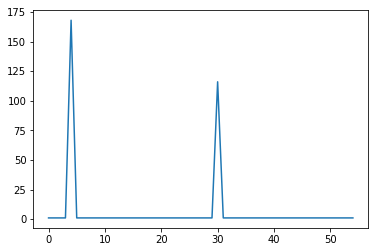

In [13]:
csv = 'p002123.psv'
print(tmp.columns)
tmp = pd.read_csv(
    '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
plt.plot(list(range(len(tmp))), tmp['Glucose'].fillna(1), label='broadcast')

### 正负样本比例

In [27]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

sick_A = [0, 0]

for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_A[1] += 1
    else:
        sick_A[0] += 1

sick_B = [0, 0]

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_B[1] += 1
    else:
        sick_B[0] += 1

Text(0.5, 1.0, '01 distribution for Sepsis')

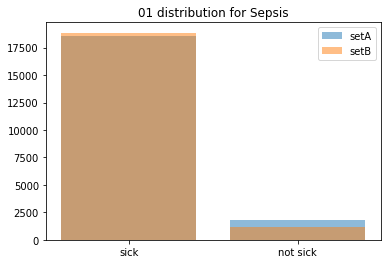

In [28]:
pA = plt.bar(['sick', 'not sick'], sick_A, label='line', alpha=0.5)
pB = plt.bar(['sick', 'not sick'], sick_B, label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("01 distribution for Sepsis")

### 正样本分析

##### 化验数据比例

In [23]:
a_traincsv = list_a
b_traincsv = list_b

chemdata_A_sick = {}
for i in range(11):
    chemdata_A_sick[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_sick[per] += 1

chemdata_B_sick = {}
for i in range(11):
    chemdata_B_sick[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_sick[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single sick person')

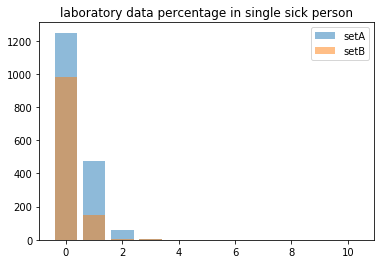

In [26]:
#chemdata_A_sick = pd.DataFrame.from_dict(chemdata_A_sick, orient='index')
#chemdata_B_sick = pd.DataFrame.from_dict(chemdata_B_sick, orient='index')
pA = plt.bar(chemdata_A_sick.index*10,
             chemdata_A_sick[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_sick.index*10,
             chemdata_B_sick[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single patient")

###### 负样本对比

In [7]:
a_traincsv = list(set(listdir('./data/trainingA/')) - set(list_a))
b_traincsv = list(set(listdir('./data/trainingB/')) - set(list_b))

chemdata_A_normal = {}
for i in range(11):
    chemdata_A_normal[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_normal[per] += 1

chemdata_B_normal = {}
for i in range(11):
    chemdata_B_normal[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_normal[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single normal person')

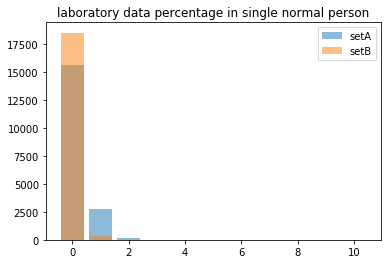

In [8]:
chemdata_A_normal = pd.DataFrame.from_dict(chemdata_A_normal, orient='index')
chemdata_B_normal = pd.DataFrame.from_dict(chemdata_B_normal, orient='index')
pA = plt.bar(chemdata_A_normal.index*10,
             chemdata_A_normal[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_normal.index*10,
             chemdata_B_normal[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single normal person")

##### 生命体征分析

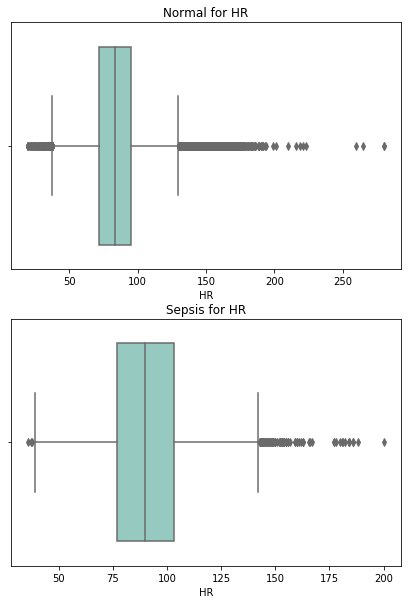

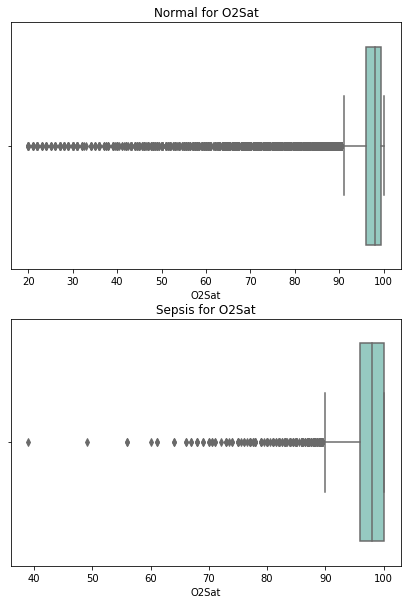

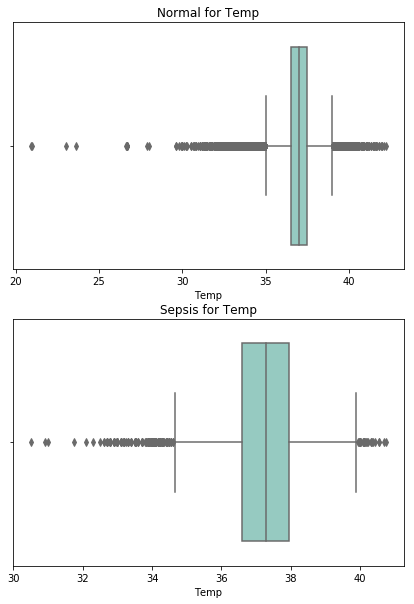

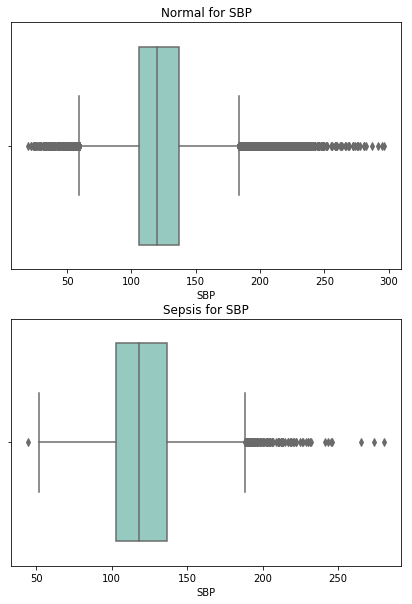

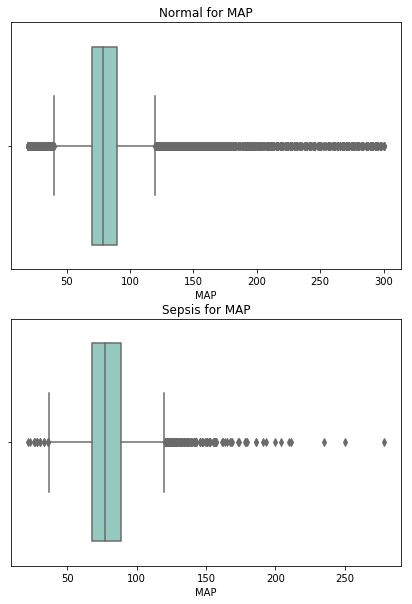

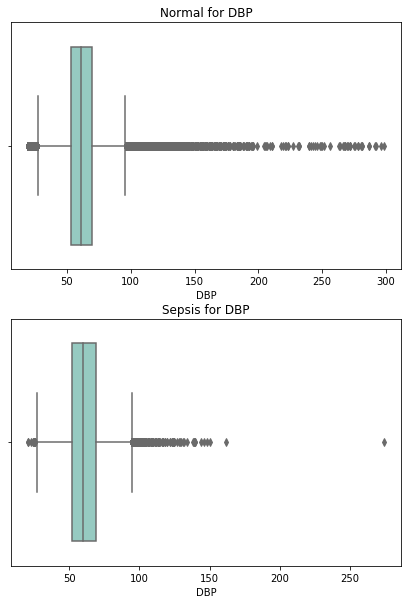

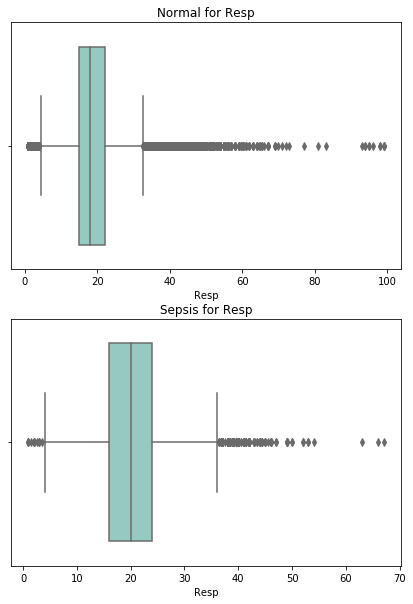

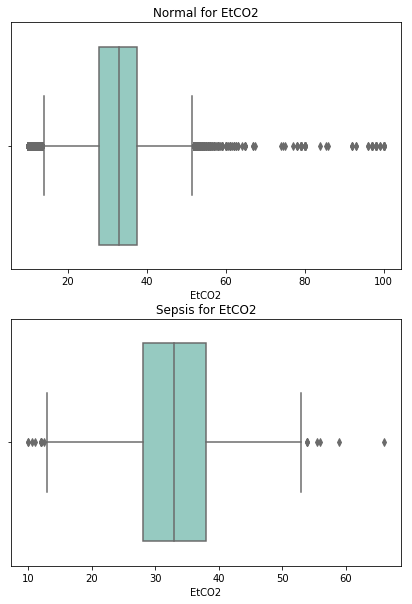

In [26]:
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
for i, var in enumerate(vital_signs):
    temp = train[[var, 'SepsisLabel']].dropna()
    temp1 = temp[temp['SepsisLabel'] == 0]
    temp2 = temp[temp['SepsisLabel'] == 1]
    fig, ax = plt.subplots(2, 1, figsize=(7, 10))

    sns.boxplot(temp1[var], ax=ax[0], palette='Set3')
    sns.boxplot(temp2[var], ax=ax[1], palette='Set3')
    ax[0].set_title("Normal for " + var)
    ax[1].set_title("Sepsis for " + var)

### 化验数据分析

##### 化验数据比例

In [7]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

chemdata_A = {}
for i in range(11):
    chemdata_A[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A[per] += 1

chemdata_B = {}
for i in range(11):
    chemdata_B[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B[per] += 1

TypeError: unsupported operand type(s) for +: 'int' and 'str'

Text(0.5, 1.0, 'laboratory data percentage in one patient')

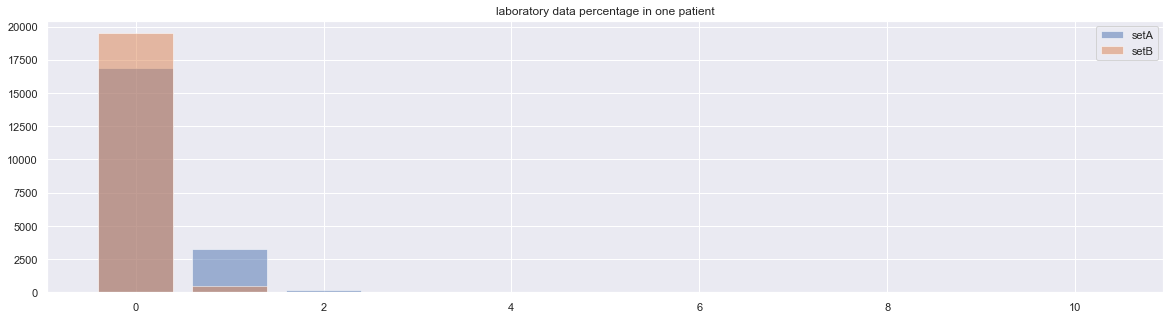

In [299]:
#chemdata_A = pd.DataFrame.from_dict(chemdata_A, orient='index')
#chemdata_B = pd.DataFrame.from_dict(chemdata_B, orient='index')
pA = plt.bar(chemdata_A.index*10, chemdata_A[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B.index*10, chemdata_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in one patient")

### 单病人观察时间长度分布

In [122]:
a_traincsv = patient_a
b_traincsv = patient_b

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv)
    distributionA[len(tmp)] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv)
    distributionB[len(tmp)] += 1

Text(0.5, 1.0, 'length distribution of patient set ')

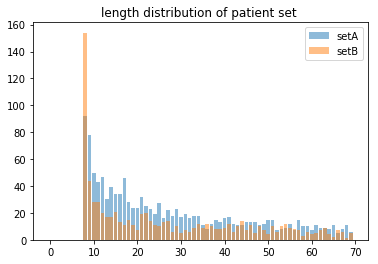

In [126]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:70], length_A[0][:70], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:70], length_B[0][:70], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("length distribution of patient set ")

### 病人平均发病时间

In [18]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionA[len(tmp[tmp['SepsisLabel'] == 0])] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionB[len(tmp[tmp['SepsisLabel'] == 0])] += 1


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'Time befored judged as sepsis ')

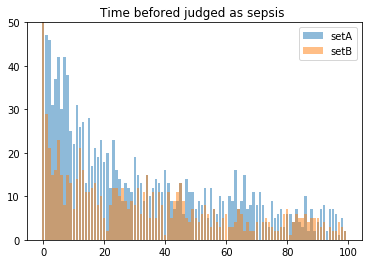

In [24]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=50)
plt.title("Time befored judged as sepsis ")

### 单病人被判断患病的时间段占比

In [102]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

one_percentage_A = {}
for i in range(11):
    one_percentage_A[i/10] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_A[percentage] += 1

one_percentage_B = {}
for i in range(11):
    one_percentage_B[i/10] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_B[percentage] += 1

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, "1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

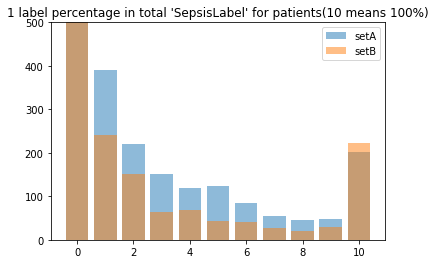

In [176]:
percentage_A = pd.DataFrame.from_dict(one_percentage_A, orient='index')
percentage_B = pd.DataFrame.from_dict(one_percentage_B, orient='index')
pA = plt.bar(percentage_A.index*10, percentage_A[0], label='line', alpha=0.5)
pB = plt.bar(percentage_B.index*10, percentage_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

### ICU种类分布

In [204]:
unit1 = 0
unit2 = 0
unit3 = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit1 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit2 += 1
    else:
        unit3 += 1

unit4 = 0
unit5 = 0
unit6 = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit4 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit5 += 1
    else:
        unit6 += 1

Text(0.5, 1.0, 'ICU kind distribution')

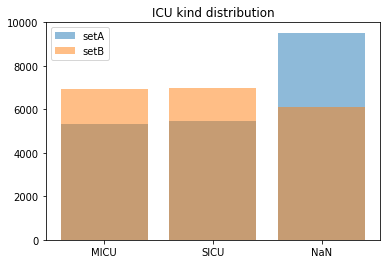

In [213]:
pA = plt.bar(['MICU', 'SICU', 'NaN'], [unit1, unit2, unit3], alpha=0.5)
pB = plt.bar(['MICU', 'SICU', 'NaN'], [unit4, unit5, unit6], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title('ICU kind distribution')

### 性别分析

In [217]:
sex = [0 for _ in range(6)]
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[0] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[1] += 1
    else:
        sex[2] += 1

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[3] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[4] += 1
    else:
        sex[5] += 1

Text(0.5, 1.0, 'sex distribution')

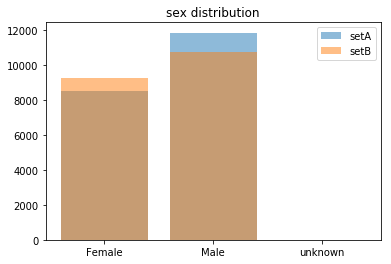

In [218]:
pA = plt.bar(['Female', 'Male', 'unknown'], sex[:3], alpha=0.5)
pB = plt.bar(['Female', 'Male', 'unknown'], sex[3:], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title('sex distribution')

### 年龄分析

In [8]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

age_A = {}
for i in range(120):
    age_A[i] = 0
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_A[age] += 1

age_B = {}
for i in range(120):
    age_B[i] = 0
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_B[age] += 1

100%|██████████| 20000/20000 [01:04<00:00, 311.63it/s]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'age distribution')

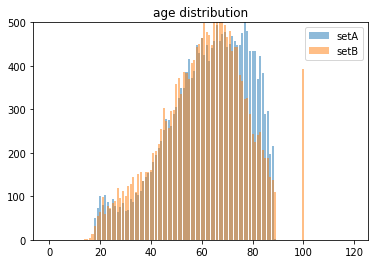

In [9]:
age_A = pd.DataFrame.from_dict(age_A, orient='index')
age_B = pd.DataFrame.from_dict(age_B, orient='index')
pA = plt.bar(age_A.index, age_A[0], label='line', alpha=0.5)
pB = plt.bar(age_B.index, age_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("age distribution")

B中最小的是14岁 A中最小的是18岁 B中有400多个100岁的

### 缺失度分析

In [239]:
train = pd.read_csv('./train.psv', sep='|')
train.shape

(1170446, 41)

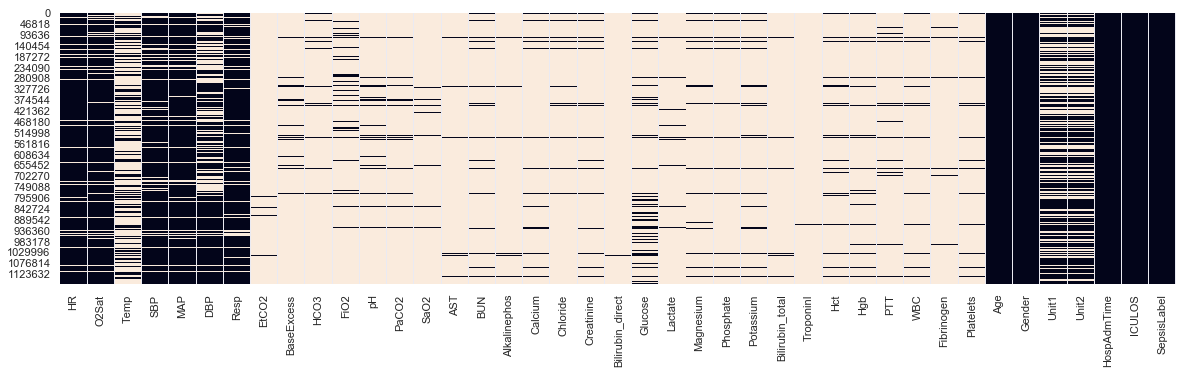

In [244]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(train.isnull(), cbar=False)

### 探索某检查与发病的关系

In [65]:
# lab_values = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
#        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
#        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
#        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
#        'Fibrinogen', 'Platelets']

lab_values = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets']



In [ ]:
a_traincsv = listdir('./data/A_single/')
b_traincsv = listdir('./data/B_single/')

distributionA = {}
for lab in lab_values:
    distributionA[lab] = []
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/A_single/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != 'normal' and list(tmp[lab])[index] != 'Missing' and list(tmp['SepsisLabel'])[index - 1] == 0 and l == -1:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                if l == -1:
                    continue
                gap = max(-1, gap - l + 1)
                distributionA[lab].append(gap)
            
        

distributionB = {}
for lab in lab_values:
    distributionB[lab] = []
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/B_single/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != 'normal' and list(tmp[lab])[index] != 'Missing' and list(tmp['SepsisLabel'])[index - 1] == 0 and l == -1:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                if l == -1:
                    continue                
                gap = max(-1, gap - l + 1)
                distributionB[lab].append(gap)
            
        



In [111]:
distributionA_ = {}
distributionB_ = {}
for feature in distributionA:
    d = distributionA[feature]
    while -1 in d:
        d.remove(-1)
    distributionA_[feature] = sum(d)/len(d) if len(d) != 0 else 0
for feature in distributionB:
    d = distributionB[feature]
    while -1 in d:
        d.remove(-1)
    distributionB_[feature] = sum(d)/len(d) if len(d) != 0 else 0

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


([<matplotlib.axis.XTick at 0x1a28103cc0>,
 <a list of 26 Text xticklabel objects>)

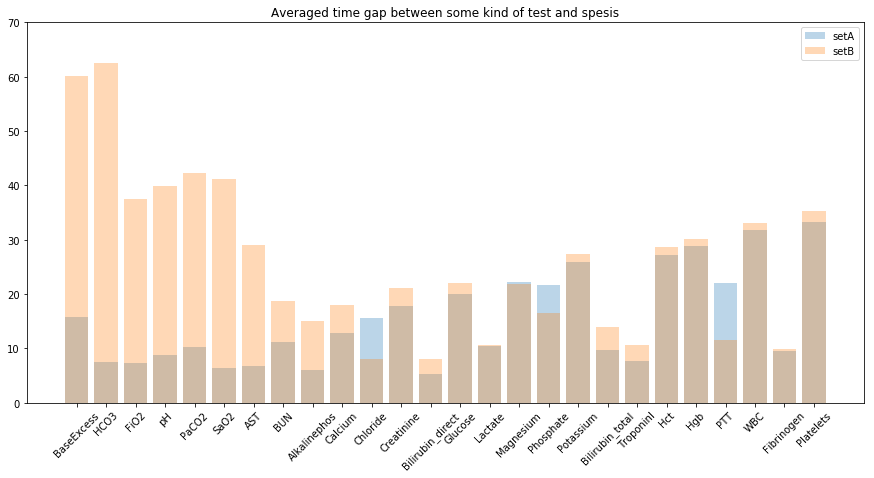

In [114]:
plt.figure(figsize=(15, 7))
length_A = pd.DataFrame.from_dict(distributionA_, orient='index')
length_B = pd.DataFrame.from_dict(distributionB_, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.3)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.3)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=70)
plt.title("Averaged time gap between some kind of test and spesis")
plt.xticks(list(range(len(list(distributionA.keys())))), list(distributionA.keys()), rotation=45, fontsize=10)

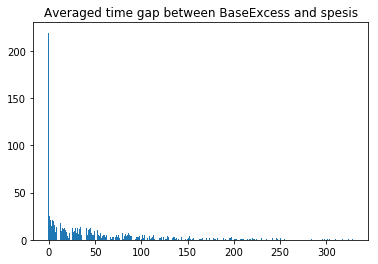

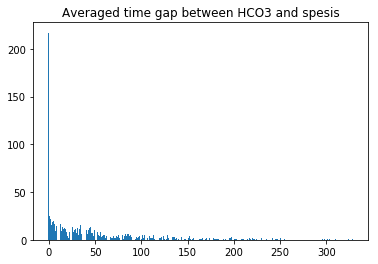

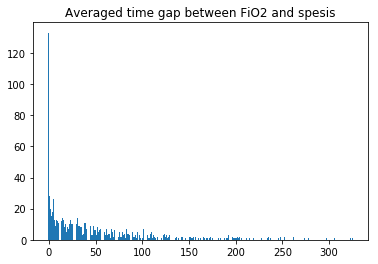

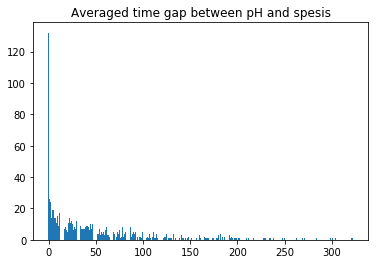

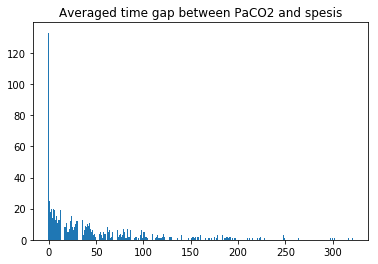

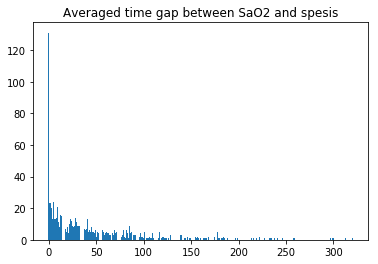

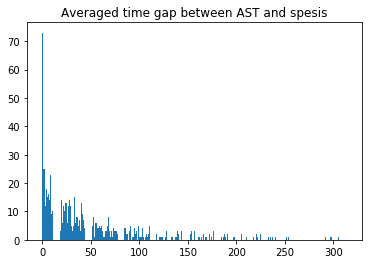

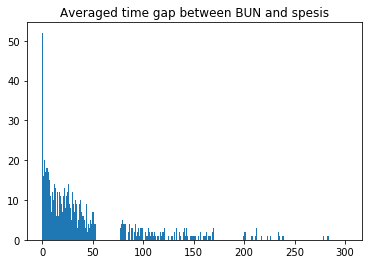

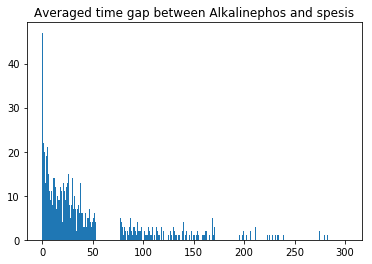

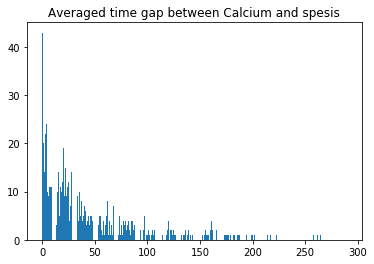

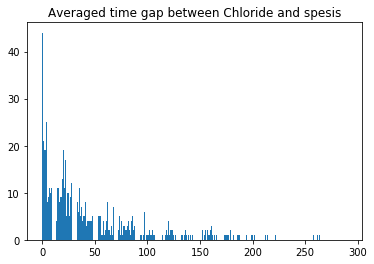

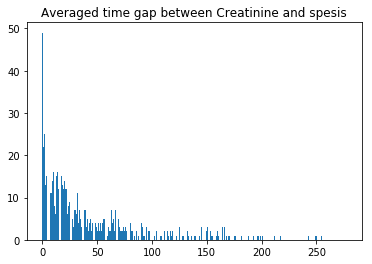

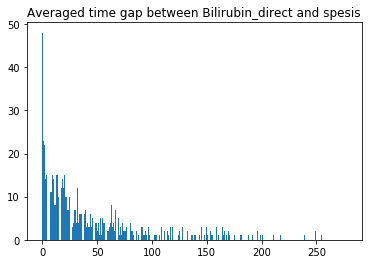

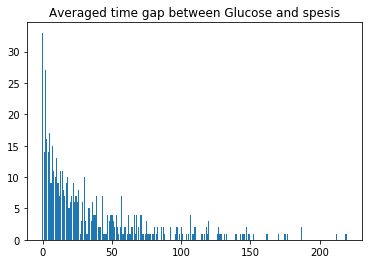

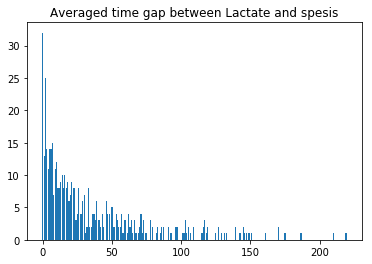

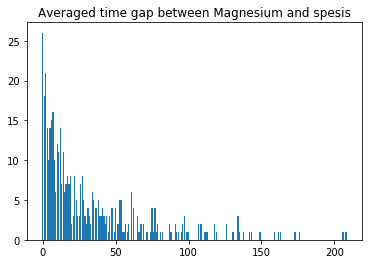

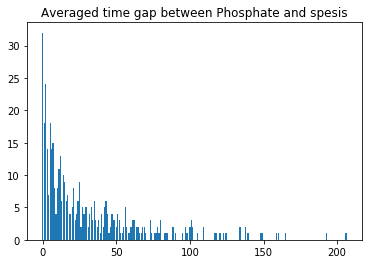

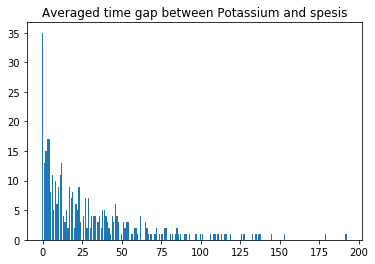

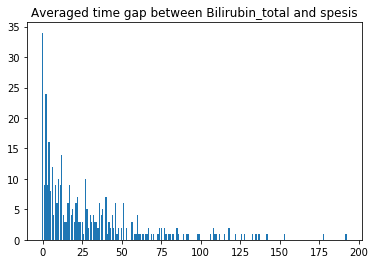

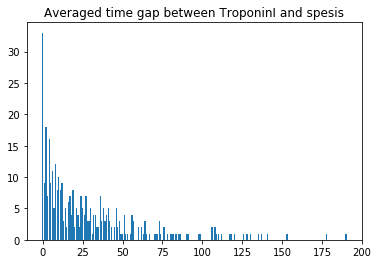

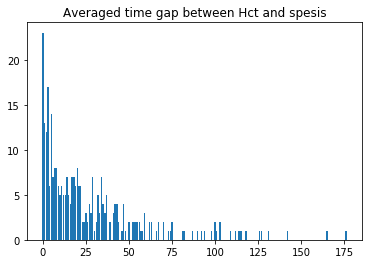

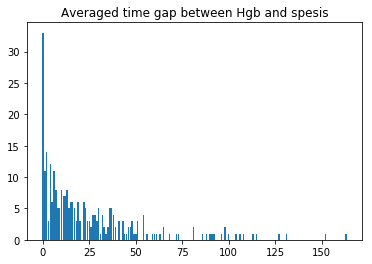

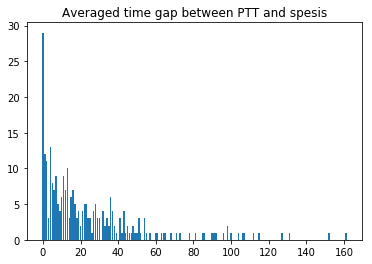

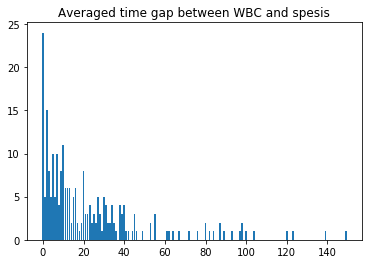

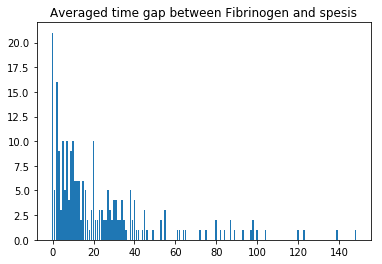

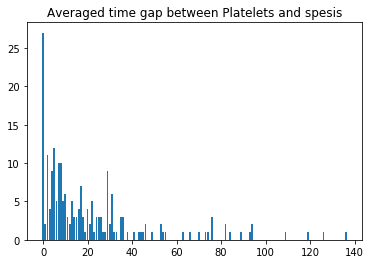

In [52]:
for i in range(len(lab_values)):
    plt.figure(i)
    plt.bar(list(Counter(distributionB[lab_values[i]])),(Counter(distributionB[lab_values[i]])).values())
    plt.title(f'Averaged time gap between {lab_values[i]} and spesis')
      

### 探索检查指标同时出现的组合

In [9]:
def cal_group(traincsv, path):
    Group = {}
    lab_values = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']
    for i, csv in enumerate(tqdm(traincsv)):
        tmp_train = pd.read_csv(path + csv, sep='|')
        tmp_train = tmp_train.fillna(-1)
        for i in range(len(tmp_train)):
            #print(tmp_train)
            group = []
            tmp = tmp_train[i:i+1]
            for feature in lab_values:
                
                if tmp[feature][i] != -1:
                    group.append(feature)
            group = tuple(group)
            if group not in Group:
                Group[group] = 1
            else:
                Group[group] += 1
    return Group


In [23]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

pathA = './data/trainingA/'
pathB = './data/trainingB/'

group_a = cal_group(a_traincsv, pathA)
group_b = cal_group(b_traincsv, pathB)

group_A = sorted(group_a, key = lambda x:group_a[x], reverse=True)
group_B = sorted(group_b, key = lambda x:group_b[x], reverse=True)
print(group_A)
print(group_B)

[(), ('FiO2',), ('Glucose',), ('Hct',), ('HCO3', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'PTT', 'WBC', 'Platelets'), ('HCO3', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets'), ('BaseExcess', 'FiO2', 'pH', 'PaCO2'), ('BaseExcess', 'pH', 'PaCO2'), ('HCO3', 'BUN', 'Chloride', 'Magnesium', 'Potassium', 'Hct', 'Hgb', 'WBC'), ('PTT',), ('HCO3', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'Hct', 'Hgb', 'PTT', 'WBC', 'Platelets'), ('BaseExcess', 'pH', 'PaCO2', 'SaO2'), ('HCO3', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium'), ('BaseExcess', 'pH', 'PaCO2', 'SaO2', 'Glucose'), ('BaseExcess', 'FiO2', 'pH', 'PaCO2', 'SaO2'), ('FiO2', 'Glucose'), ('BaseExcess', 'pH', 'PaCO2', 'Lactate'), ('BaseExcess', 'pH'), ('BaseExc

In [51]:
DataFrame([group_A,[group_a[v] for v in group_A]], index=['group','numbers']).T.to_csv('A_group.csv')
DataFrame([group_B,[group_b[v] for v in group_B]], index=['group','numbers']).T.to_csv('B_group.csv')


# Data processing

In [6]:
train = pd.read_csv('./data/train.psv', sep='|')
len(train)

1552265

decoration

In [44]:
def mission_complete(func):
    def wrapper(train):
        #print(f'{func} is running')
        return func(train)
    return wrapper


## No FE

In [9]:
feature_org = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

In [ ]:
a_traincsv = listdir('./data/trainingA/')
for i,csv in tqdm(enumerate(a_traincsv)):
    with open(f"./data/A_nfe/A_nfe_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingA/' + csv, sep='|')
        cur_train.fillna(method='pad', inplace=True)
        cur_train.fillna(0, inplace=True)
        cur_train = feature_engineer_cut(cur_train)
        pickle.dump(cur_train, file)

3758it [10:05,  6.02it/s]

In [ ]:
b_traincsv = listdir('./data/trainingB/')
for i,csv in tqdm(enumerate(b_traincsv)):
    with open(f"./data/B_nfe/B_nfe_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingB/' + csv, sep='|')
        cur_train.fillna(method='pad', inplace=True)
        cur_train.fillna(0, inplace=True)
        cur_train = feature_engineer_cut(cur_train)
        pickle.dump(cur_train, file)

### for A

In [17]:
kind = 'nfe'
a_pkl = listdir(f'./data/A_{kind}/')
trainA = [[] for _ in range(42)]

for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/A_{kind}/A_{kind}_{i * 500}.pkl', 'rb') as file:
        trainA[i] = pickle.load(file)
    for _, pkl in enumerate(tqdm(a_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/A_{kind}/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainA[i] = pd.merge(trainA[i], tmp,how='outer')
            
with open(f'./data/A_{kind}/A_{kind}_{20001}.pkl', 'rb') as file:
    trainA[40] = pickle.load(file)

for _, pkl in tqdm(enumerate(a_pkl[40 * 500 + 2:])):
    with open(f'./data/A_{kind}/' + pkl, 'rb') as file:
        tmp = pickle.load(file)
        trainA[40] = pd.merge(trainA[40], tmp,how='outer')
    
trainA[41] = trainA[0]
with open(f"./data/A_{kind}/A{kind}.pkl", 'wb') as file_A:
    for i in range(41):
        tmp = trainA[i]
        trainA[41] = pd.merge(trainA[41], tmp,how='outer')
    pickle.dump(trainA[41], file_A)


  0%|          | 0/73 [00:00<?, ?it/s]

set****************************0******************************


EOFError: Ran out of input

### for B

In [ ]:
kind = 'nfe'
b_pkl = listdir(f'./data/B_{kind}/')
trainB = [[] for _ in range(41)]
for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/B_{kind}/B_{kind}_{i * 500}.pkl', 'rb') as file:
        trainB[i] = pickle.load(file)
        
    for _, pkl in enumerate(tqdm(b_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/B_{kind}/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainB[i] = pd.merge(trainB[i], tmp,how='outer')

In [ ]:
trainB[40] = trainB[0]
with open(f"./data/B_{kind}/B{kind}.pkl", 'wb') as file_B:
    for i in tqdm(range(40)):
        tmp = trainB[i]
        trainB[40] = pd.merge(trainB[40], tmp,how='outer')
    pickle.dump(trainB[40], file_B)


### for AB

In [ ]:
with open(f"./data/{kind}/{kind}.pkl", 'wb') as file_AB:
    with open(f"./data/A_{kind}/A{kind}.pkl", 'rb') as file_A:
        cutA = pickle.load(file_A)
    with open(f"./data/B_{kind}/B{kind}.pkl", 'rb') as file_B:
        cutB = pickle.load(file_B)
        
    cut = pd.merge(cutA, cutB,how='outer')
    
    pickle.dump(cut, file_AB)

## Kill the NaN

去掉每一个psv中的NaN 

In [45]:
feature_org = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

In [46]:
a_traincsv = listdir('./data/trainingA/')
for i,csv in tqdm(enumerate(a_traincsv)):
    with open(f"./data/processedA/trainA_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingA/' + csv, sep='|')
        cur_train = cur_train.fillna(method='pad')
        pickle.dump(cur_train, file)
        
b_traincsv = listdir('./data/trainingB/')
for i,csv in tqdm(enumerate(b_traincsv)):
    with open(f"./data/processedB/trainB_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingB/' + csv, sep='|')
        cur_train = cur_train.fillna(method='pad')
        pickle.dump(cur_train, file)

2893it [00:12, 232.05it/s]

KeyboardInterrupt: 

## 将ABset分别存成一个大pkl文件

### for processed

In [ ]:
a_pkl = listdir('./data/processedA/')
b_pkl = listdir('./data/processedB/')

trainA = [[] for _ in range(42)]
trainB = [[] for _ in range(42)]

for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/processedA/trainA_{i * 500}.pkl', 'rb') as file:
        trainA[i] = pickle.load(file)
    with open(f'./data/processedB/trainB_{i * 500}.pkl', 'rb') as file:
        trainB[i] = pickle.load(file)
        
    for _, pkl in enumerate(tqdm(a_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/processedA/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainA[i] = pd.merge(trainA[i], tmp,how='outer')
    
#     for _, pkl in enumerate(tqdm(b_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
#         with open(f'./data/processedB/' + pkl, 'rb') as file:
#             tmp = pickle.load(file)
#             trainB[i] = pd.merge(trainB[i], tmp,how='outer')

            
with open(f'./data/processedA/trainA_{20001}.pkl', 'rb') as file:
    trainA[40] = pickle.load(file)

for _, pkl in tqdm(enumerate(a_pkl[40 * 500 + 2:])):
    with open(f'./data/processedA/' + pkl, 'rb') as file:
        tmp = pickle.load(file)
        trainA[40] = pd.merge(trainA[40], tmp,how='outer')
    


In [ ]:
trainA[41] = trainA[0]
with open(f"./data/processedA/trainA.pkl", 'wb') as file_A:
    for i in range(41):
        tmp = trainA[i]
        trainA[41] = pd.merge(trainA[41], tmp,how='outer')
    pickle.dump(trainA[41], file_A)


In [ ]:
trainB[41] = trainB[0]
with open(f"./data/processedB/trainB.pkl", 'wb') as file_B:
    for i in range(1,40):
        tmp = trainB[i]
        trainB[41] = pd.merge(trainB[41], tmp,how='outer')
    pickle.dump(trainB[41], file_B)

### for cutA

In [80]:
a_pkl = listdir('./data/A_cut/')
trainA = [[] for _ in range(42)]

for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/A_cut/A_cut_{i * 500}.pkl', 'rb') as file:
        trainA[i] = pickle.load(file)
    for _, pkl in enumerate(tqdm(a_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/A_cut/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainA[i] = pd.merge(trainA[i], tmp,how='outer')
            
with open(f'./data/A_cut/A_cut_{20001}.pkl', 'rb') as file:
    trainA[40] = pickle.load(file)

for _, pkl in tqdm(enumerate(a_pkl[40 * 500 + 2:])):
    with open(f'./data/A_cut/' + pkl, 'rb') as file:
        tmp = pickle.load(file)
        trainA[40] = pd.merge(trainA[40], tmp,how='outer')
    


  1%|          | 3/500 [00:00<00:22, 22.41it/s]

set****************************0******************************


  1%|          | 4/500 [00:00<00:15, 31.49it/s]

set****************************1******************************


  1%|          | 3/500 [00:00<00:18, 26.67it/s]

set****************************2******************************


  1%|          | 3/500 [00:00<00:18, 27.10it/s]

set****************************3******************************


  1%|          | 4/500 [00:00<00:15, 31.47it/s]

set****************************4******************************


  1%|          | 4/500 [00:00<00:16, 30.08it/s]

set****************************5******************************


  1%|          | 3/500 [00:00<00:17, 28.38it/s]

set****************************6******************************


  1%|          | 4/500 [00:00<00:13, 37.28it/s]

set****************************7******************************


  1%|          | 4/500 [00:00<00:15, 32.03it/s]

set****************************8******************************


  1%|          | 4/500 [00:00<00:14, 34.47it/s]

set****************************9******************************


  1%|          | 4/500 [00:00<00:15, 32.65it/s]

set****************************10******************************


  1%|          | 4/500 [00:00<00:15, 31.75it/s]

set****************************11******************************


  1%|          | 3/500 [00:00<00:16, 29.72it/s]

set****************************12******************************


  1%|          | 4/500 [00:00<00:14, 33.66it/s]

set****************************13******************************


  1%|          | 3/500 [00:00<00:16, 29.34it/s]

set****************************14******************************


  1%|          | 4/500 [00:00<00:15, 32.48it/s]

set****************************15******************************


  1%|          | 4/500 [00:00<00:15, 32.39it/s]

set****************************16******************************


  1%|          | 4/500 [00:00<00:13, 36.89it/s]

set****************************17******************************


  1%|          | 4/500 [00:00<00:14, 33.26it/s]

set****************************18******************************


  1%|          | 4/500 [00:00<00:13, 37.21it/s]

set****************************19******************************


  1%|          | 4/500 [00:00<00:13, 37.18it/s]

set****************************20******************************


  1%|          | 4/500 [00:00<00:13, 36.90it/s]

set****************************21******************************


  1%|          | 4/500 [00:00<00:15, 32.74it/s]

set****************************22******************************


  1%|          | 4/500 [00:00<00:13, 37.50it/s]

set****************************23******************************


  1%|          | 4/500 [00:00<00:13, 37.28it/s]

set****************************24******************************


  1%|          | 4/500 [00:00<00:14, 34.43it/s]

set****************************25******************************


  1%|          | 4/500 [00:00<00:14, 33.92it/s]

set****************************26******************************


  1%|          | 4/500 [00:00<00:13, 37.13it/s]

set****************************27******************************


  1%|          | 3/500 [00:00<00:17, 28.64it/s]

set****************************28******************************


  1%|          | 4/500 [00:00<00:13, 37.24it/s]

set****************************29******************************


  1%|          | 4/500 [00:00<00:15, 32.84it/s]

set****************************30******************************


  1%|          | 4/500 [00:00<00:13, 36.40it/s]

set****************************31******************************


  1%|          | 4/500 [00:00<00:12, 39.95it/s]

set****************************32******************************


  1%|          | 4/500 [00:00<00:12, 39.55it/s]

set****************************33******************************


  1%|          | 4/500 [00:00<00:13, 35.97it/s]

set****************************34******************************


  1%|          | 4/500 [00:00<00:12, 38.75it/s]

set****************************35******************************


  1%|          | 4/500 [00:00<00:12, 39.20it/s]

set****************************36******************************


  1%|          | 4/500 [00:00<00:13, 37.20it/s]

set****************************37******************************


 78%|███████▊  | 391/500 [00:43<00:20,  5.21it/s]

EOFError: Ran out of input

In [85]:
trainA[41] = trainA[0]
with open(f"./data/A_cut/Acut.pkl", 'wb') as file_A:
    for i in range(41):
        tmp = trainA[i]
        trainA[41] = pd.merge(trainA[41], tmp,how='outer')
    pickle.dump(trainA[41], file_A)


### for cutB

In [17]:
b_pkl = listdir('./data/B_cut/')
trainB = [[] for _ in range(41)]
for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/B_cut/B_cut_{i * 500}.pkl', 'rb') as file:
        trainB[i] = pickle.load(file)
        
    for _, pkl in enumerate(tqdm(b_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/B_cut/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainB[i] = pd.merge(trainB[i], tmp,how='outer')

  1%|          | 3/500 [00:00<00:17, 28.32it/s]

set****************************0******************************


  1%|          | 4/500 [00:00<00:15, 31.88it/s]

set****************************1******************************


  1%|          | 5/500 [00:00<00:12, 40.44it/s]

set****************************2******************************


  1%|          | 5/500 [00:00<00:12, 41.07it/s]

set****************************3******************************


  1%|          | 5/500 [00:00<00:12, 39.87it/s]

set****************************4******************************


  1%|          | 4/500 [00:00<00:12, 38.80it/s]

set****************************5******************************


  1%|          | 4/500 [00:00<00:12, 39.47it/s]

set****************************6******************************


  1%|          | 5/500 [00:00<00:12, 41.01it/s]

set****************************7******************************


  1%|          | 4/500 [00:00<00:12, 39.95it/s]

set****************************8******************************


  1%|          | 4/500 [00:00<00:12, 39.05it/s]

set****************************9******************************


  1%|          | 5/500 [00:00<00:12, 40.41it/s]

set****************************10******************************


  1%|          | 3/500 [00:00<00:18, 27.00it/s]

set****************************11******************************


  1%|          | 4/500 [00:00<00:12, 39.94it/s]

set****************************12******************************


  1%|          | 4/500 [00:00<00:12, 39.45it/s]

set****************************13******************************


  1%|          | 5/500 [00:00<00:12, 41.18it/s]

set****************************14******************************


  1%|          | 5/500 [00:00<00:11, 41.51it/s]

set****************************15******************************


  1%|          | 4/500 [00:00<00:12, 38.99it/s]

set****************************16******************************


  1%|          | 5/500 [00:00<00:12, 38.55it/s]

set****************************17******************************


  1%|          | 4/500 [00:00<00:12, 39.33it/s]

set****************************18******************************


  1%|          | 3/500 [00:00<00:17, 27.68it/s]

set****************************19******************************


  1%|          | 3/500 [00:00<00:24, 20.20it/s]

set****************************20******************************


  1%|          | 4/500 [00:00<00:12, 39.98it/s]

set****************************21******************************


  1%|          | 4/500 [00:00<00:13, 37.33it/s]

set****************************22******************************


  1%|          | 5/500 [00:00<00:12, 38.65it/s]

set****************************23******************************


  1%|          | 5/500 [00:00<00:12, 40.75it/s]

set****************************24******************************


  1%|          | 5/500 [00:00<00:12, 40.62it/s]

set****************************25******************************


  1%|          | 4/500 [00:00<00:12, 38.18it/s]

set****************************26******************************


  1%|          | 4/500 [00:00<00:14, 34.00it/s]

set****************************27******************************


  1%|          | 4/500 [00:00<00:13, 36.90it/s]

set****************************28******************************


  1%|          | 4/500 [00:00<00:15, 31.38it/s]

set****************************29******************************


  1%|          | 4/500 [00:00<00:12, 39.13it/s]

set****************************30******************************


  1%|          | 5/500 [00:00<00:12, 40.65it/s]

set****************************31******************************


  1%|          | 4/500 [00:00<00:12, 39.65it/s]

set****************************32******************************


  1%|          | 4/500 [00:00<00:12, 38.34it/s]

set****************************33******************************


  1%|          | 5/500 [00:00<00:12, 40.96it/s]

set****************************34******************************


  1%|          | 5/500 [00:00<00:12, 41.08it/s]

set****************************35******************************


  1%|          | 5/500 [00:00<00:12, 40.66it/s]

set****************************36******************************


  1%|          | 5/500 [00:00<00:12, 38.91it/s]

set****************************37******************************


  1%|          | 4/500 [00:00<00:14, 33.67it/s]

set****************************38******************************


  1%|          | 5/499 [00:00<00:12, 39.39it/s]

set****************************39******************************


100%|██████████| 499/499 [01:00<00:00,  4.79it/s]


In [23]:
trainB[40] = trainB[0]
with open(f"./data/B_cut/Bcut.pkl", 'wb') as file_B:
    for i in tqdm(range(40)):
        tmp = trainB[i]
        trainB[40] = pd.merge(trainB[40], tmp,how='outer')
    pickle.dump(trainB[40], file_B)


### AB big one cut

In [32]:
with open(f"./data/cut/cut.pkl", 'wb') as file_AB:
    with open(f"./data/A_cut/Acut.pkl", 'rb') as file_A:
        cutA = pickle.load(file_A)
    with open(f"./data/B_cut/Bcut.pkl", 'rb') as file_B:
        cutB = pickle.load(file_B)
        
    cut = pd.merge(cutA, cutB,how='outer')
    
    pickle.dump(cut, file_AB)

## Feature Engineering

### Main

In [3]:
def mission_complete(func):
    def wrapper(train):
        #print(f'{func} is running')
        return func(train)
    return wrapper

@mission_complete
def feature_engineer_cut(train):
    tmp = train.tail(1)
    while len(train) <= 100:
        train = pd.concat([train,tmp],ignore_index=True,)
    if len(train) > 100:
        train = train[:100]
    return train
    
@mission_complete
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),'custom_hr'] = 'abnormal'
    train['custom_hr'] = train['custom_hr'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 'custom_temp'] = 'abnormal'
    train['custom_temp'] = train['custom_temp'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <10, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=10) & (train['Age'] <65), 'custom_age'] = 'adult'
    return train

@mission_complete
def feature_engineer_o2sat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 'custom_o2sat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 'custom_o2sat'] = 'abnormal'
    train['custom_o2sat'] = train['custom_o2sat'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'
    train.loc[(train['SBP'].between(90,120, inclusive=True)) & (train['DBP'].between(60,80, inclusive=True)), 'custom_bp'] = 'normal'
    train.loc[(train['SBP'].between(120,140, inclusive=True)) & (train['DBP'].between(80,90, inclusive=True)), 'custom_bp'] = 'elevated'
    train.loc[(train['SBP'] > 140 ) & (train['DBP'] > 90 ), 'custom_bp'] = 'high'
    train['custom_bp'] = train['custom_bp'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & (train['Age'] <1) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),'custom_resp'] = 'abnormal'
    train['custom_resp'] = train['custom_resp'].fillna('Missing')
    return train
  
@mission_complete
def feature_engineer_ph(train):
    feature = 'pH'
    custom = 'custom_ph'
    train.loc[(train[feature] >= 7.35) & (train[feature] <= 7.45), 'custom_ph'] = 'normal'
    train.loc[(train[feature] < 7.35) | (train[feature] > 7.45), 'custom_ph'] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

    
@mission_complete
def feature_engineer_etco2(train):
    train.loc[(train['EtCO2'] >= 35) & (train['EtCO2'] <=45), 'custom_etco2'] = 'normal'
    train.loc[(train['EtCO2'] < 35) | (train['EtCO2'] > 45), 'custom_etco2'] = 'abnormal'
    train['custom_etco2'] = train['custom_etco2'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_baseexcess(train):
    feature = 'BaseExcess'
    train.loc[(train['BaseExcess'] >= -3) & (train['BaseExcess'] <= 3), 'custom_be'] = 'normal'
    train.loc[(train['BaseExcess'] < -3) | (train['BaseExcess'] > 3), 'custom_be'] = 'abnormal'
    train['custom_be'] = train['custom_be'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_hco3(train):
    feature = 'HCO3'
    train.loc[(train[feature] >= 22) & (train[feature] <= 27), 'custom_hco3'] = 'normal'
    train.loc[(train[feature] < 22) | (train[feature] > 27), 'custom_hco3'] = 'abnormal'
    train['custom_hco3'] = train['custom_hco3'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_fso2(train):
    feature = 'FiO2'
    feature_ = 'SaO2'
    custom = 'custom_fio2'
    custom_ = 'custom_sao2'
    
    train.loc[(train[feature] >= 0.18) & (train[feature] <= 0.25), custom] = 'normal'
    train.loc[(train[feature] < 0.18) | (train[feature] > 0.25), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= 94) & (train[feature_] <= 100), custom_] = 'normal'
    train.loc[(train[feature_] < 94) | (train[feature_] > 100), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train

@mission_complete
def feature_engineer_paco2(train):
    feature = 'PaCO2'
    custom = 'custom_paco2'
    train.loc[(train[feature] >= 38) & (train[feature] <= 42), 'custom_paco2'] = 'normal'
    train.loc[(train[feature].between(42, 59)), 'custom_paco2'] = 'moderate'
    train.loc[(train[feature] >= 60), 'custom_paco2'] = 'serious'
    train.loc[(train[feature] < 38), 'custom_paco2'] = 'low'

    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_ast(train):
    feature = 'AST'
    up = 34
    down = 6
    up_ = 40
    down_ = 8
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) | (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_bun(train):
    feature = 'BUN'
    up = 21
    down = 7
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up, 60)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 60), 'custom_' + feature.lower()] = 'serious'
    train.loc[(train['BUN'] != None) & (train['Creatinine'] != None) & ((train['BUN']/train['Creatinine'] >= 10) | (train['BUN']/train['Creatinine'] <= 20)), 'custom_BC_ratio'] = 'normal'
    train[custom] = train[custom].fillna('Missing')
    train['custom_BC_ratio'] = train['custom_BC_ratio'].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_creatinine(train):
    feature = 'Creatinine'
    up = 0.7
    down = 1.2
    up_ = 0.5
    down_ = 1.0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_alkalinephos(train):
    feature = 'Alkalinephos'
    up = 147
    down = 44
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_calcium(train):
    feature = 'Calcium'
    up = 10.2
    down = 8.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train

@mission_complete
def feature_engineer_chloride(train):
    feature = 'Chloride'
    up = 98
    down = 106
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] >= 70) & (train[feature] < down)) | (train[feature] > up & (train[feature] <= 120)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < 70) | (train[feature] > 120), 'custom_' + feature.lower()] = 'serious'

    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_bilirubin(train):
    feature = 'Bilirubin_direct'
    feature_ = 'Bilirubin_total'
    custom = 'custom_bd'
    custom_ = 'custom_bt'
    up = 0.3
    down = -1000
    up_ = 1.2
    down_ = 0.1
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), custom] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= down_) & (train[feature_] <= up_), custom_] = 'normal'
    train.loc[(train[feature_] < down_) | (train[feature_] > up_), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train

@mission_complete
def feature_engineer_glucose(train):
    feature = 'Glucose'
    up = 125
    down = 100
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature].between(up, 200)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= 200), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_lactate(train):
    feature = 'Lactate'
    up = 18.2
    down = 4.55
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_magnesium(train):
    feature = 'Magnesium'
    up = 1.1
    down = 0.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up,2.9)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 2.9) , 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_phosphate(train):
    feature = 'Phosphate'
    up = 4.5
    down = 2.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_potassium(train):
    feature = 'Potassium'
    up = 5.2
    down = 3.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train[feature] <= 6), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] > 6), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_troponin(train):
    feature = 'TroponinI'
    up = 0.4
    down = 0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_hct(train):
    feature = 'Hct'
    up = 52
    down = 45
    up_ = 48
    down_ = 37
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train

@mission_complete
def feature_engineer_hgb(train):
    feature = 'Hgb'
    up = 17.5
    down = 13.5
    up_ = 15.5
    down_ = 12
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_ptt(train):
    feature = 'PTT'
    up = 35
    down = 25
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_wbc(train):
    feature = 'WBC'
    up = 11
    down = 4.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_fibrinogen(train):
    feature = 'Fibrinogen'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_platelets(train):
    feature = 'Platelets'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_unit(train):

    train.loc[train['Unit1'] == 1, 'Unit'] = 1
    train.loc[train['Unit2'] == 1, 'Unit'] = 2
    train['Unit'] = train['Unit'].fillna(3)

    return train

def feature_engineer(train):    
    print('Begin!')
    train = feature_engineer_age(train)
    train = feature_engineer_blood_pressure(train)
    train = feature_engineer_hr(train)
    train = feature_engineer_o2sat(train)
    train = feature_engineer_temp(train)
    train = feature_engineer_resp_rate(train)
    train = feature_engineer_etco2(train)

    train = feature_engineer_baseexcess(train)
    train = feature_engineer_hco3(train)
    train = feature_engineer_fso2(train)
    train = feature_engineer_ph(train)
    train = feature_engineer_paco2(train)
    train = feature_engineer_ast(train)
    train = feature_engineer_bun(train)
    train = feature_engineer_alkalinephos(train)
    train = feature_engineer_calcium(train)
    train = feature_engineer_chloride(train)
    train = feature_engineer_creatinine(train)
    train = feature_engineer_bilirubin(train)
    train = feature_engineer_glucose(train)
    train = feature_engineer_lactate(train)
    train = feature_engineer_magnesium(train)
    train = feature_engineer_phosphate(train)
    train = feature_engineer_potassium(train)
    train = feature_engineer_troponin(train)
    train = feature_engineer_hct(train)
    train = feature_engineer_hgb(train)
    train = feature_engineer_ptt(train)
    train = feature_engineer_wbc(train)
    train = feature_engineer_fibrinogen(train)
    train = feature_engineer_platelets(train)
    train = feature_engineer_unit(train)
    train = feature_engineer_cut(train)
    print('Data processed!')
    
    return train



### Vital Signs

#### CUT

In [13]:
@mission_complete
def feature_engineer_cut(train):
    tmp = train.tail(1)
    while len(train) <= 100:
        train = pd.concat([train,tmp],ignore_index=True,)
    if len(train) > 100:
        train = train[:100]
    return train

#### Heart Rate (beats per minute)

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. 

In [47]:
@mission_complete
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),'custom_hr'] = 'abnormal'
    train['custom_hr'] = train['custom_hr'].fillna('Missing')
    return train

#### Temperature (Deg C)

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C. 

In [48]:
@mission_complete
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 'custom_temp'] = 'abnormal'
    train['custom_temp'] = train['custom_temp'].fillna('Missing')
    return train


#### Age

Categorizing patient based on age to old, infant and adult

In [49]:
@mission_complete
def feature_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <10, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=10) & (train['Age'] <65), 'custom_age'] = 'adult'
    return train

#### O2Stat (%)

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [50]:
@mission_complete
def feature_engineer_o2sat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 'custom_o2sat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 'custom_o2sat'] = 'abnormal'
    train['custom_o2sat'] = train['custom_o2sat'].fillna('Missing')
    return train


#### SBP DBP (mm Hg)

SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [51]:
@mission_complete
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'
    train.loc[(train['SBP'].between(90,120, inclusive=True)) & (train['DBP'].between(60,80, inclusive=True)), 'custom_bp'] = 'normal'
    train.loc[(train['SBP'].between(120,140, inclusive=True)) & (train['DBP'].between(80,90, inclusive=True)), 'custom_bp'] = 'elevated'
    train.loc[(train['SBP'] > 140 ) & (train['DBP'] > 90 ), 'custom_bp'] = 'high'
    train['custom_bp'] = train['custom_bp'].fillna('Missing')
    return train

#### Respiration Rate (breath per minute)

Respiration rate for healthy adults is between 12 and 20. 

In [52]:
@mission_complete
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & (train['Age'] <1) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),'custom_resp'] = 'abnormal'
    train['custom_resp'] = train['custom_resp'].fillna('Missing')
    return train
  

#### EtCO2 (mm Hg)

Summary. End-tidal CO2 (EtCO2) monitoring is a noninvasive technique which measures the partial pressure or maximal concentration of carbon dioxide (CO2) at the end of an exhaled breath, which is expressed as a percentage of CO2 or mmHg. The normal values are 5% to 6% CO2, which is equivalent to 35-45 mmHg. 

In [53]:
@mission_complete
def feature_engineer_etco2(train):
    train.loc[(train['EtCO2'] >= 35) & (train['EtCO2'] <=45), 'custom_etco2'] = 'normal'
    train.loc[(train['EtCO2'] < 35) | (train['EtCO2'] > 45), 'custom_etco2'] = 'abnormal'
    train['custom_etco2'] = train['custom_etco2'].fillna('Missing')
    return train


#### SepsisTime(hour)

This is the time between documented and diagnosed as sepsis.

In [31]:
@mission_complete
def feature_engineer_sepsistime(train):
    train.loc['custom_time'] = len(train[train['SepsisLabel'] == 0])
    return train


### Laboratory values

#### BaseExcess (mmol/L)

Base excess. Medical diagnostics. LOINC. 11555-0. In physiology, base excess and base deficit refer to an excess or deficit, respectively, in the amount of base present in the blood. -3 to 3 is normal range.

In [54]:
@mission_complete
def feature_engineer_baseexcess(train):
    feature = 'BaseExcess'
    train.loc[(train['BaseExcess'] >= -3) & (train['BaseExcess'] <= 3), 'custom_be'] = 'normal'
    train.loc[(train['BaseExcess'] < -3) | (train['BaseExcess'] > 3), 'custom_be'] = 'abnormal'
    train['custom_be'] = train['custom_be'].fillna('Missing')
    return train


#### HCO3 (mmol/L)

实际碳酸氢盐,在隔绝空气的血液标本在实验室条件下所测得的血浆碳酸氢盐值。正常情况下为22-27mmol/L,平均值为24mmol/L,动静脉血大致相等

In [55]:
@mission_complete
def feature_engineer_hco3(train):
    feature = 'HCO3'
    train.loc[(train[feature] >= 22) & (train[feature] <= 27), 'custom_hco3'] = 'normal'
    train.loc[(train[feature] < 22) | (train[feature] > 27), 'custom_hco3'] = 'abnormal'
    train['custom_hco3'] = train['custom_hco3'].fillna('Missing')
    return train


#### FiO2 & SaO2 (%)

Partial pressure of oxygen (PaO2): 75 to 100 millimeters of mercury (mm Hg), or 10.5 to 13.5 kilopascal (kPa) 

SaO2: Normal arterial oxygen is approximately 75 to 100 millimeters of mercury (mm Hg). Values under 60 mm Hg usually indicate the need for supplemental oxygen. Normal pulse oximeter readings usually range from 95 to 100 percent. Values under 90 percent are considered low

FiO2: Normal range (PaO2/FiO2): = 400

In [56]:
@mission_complete
def feature_engineer_fso2(train):
    feature = 'FiO2'
    feature_ = 'SaO2'
    custom = 'custom_fio2'
    custom_ = 'custom_sao2'
    
    train.loc[(train[feature] >= 0.18) & (train[feature] <= 0.25), custom] = 'normal'
    train.loc[(train[feature] < 0.18) | (train[feature] > 0.25), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= 94) & (train[feature_] <= 100), custom_] = 'normal'
    train.loc[(train[feature_] < 94) | (train[feature_] > 100), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train


#### PaCO2 (mm Hg)

Partial pressure of carbon dioxide (PaCO2): 38 to 42 mm Hg (5.1 to 5.6 kPa) Arterial blood pH: 7.38 to 7.42. 

Like most medical normal values and ranges, the definition can vary slightly, but generally the following definitions apply: Mild hypoxemia: PaO2 = 60 to 79 mmHg. Moderate hypoxemia: PaO2 = 40 to 59 mmHg. Severe hypoxemia: PaO2 < 40 mmHg.

In [57]:
@mission_complete
def feature_engineer_paco2(train):
    feature = 'PaCO2'
    custom = 'custom_paco2'
    train.loc[(train[feature] >= 38) & (train[feature] <= 42), 'custom_paco2'] = 'normal'
    train.loc[(train[feature].between(42, 59)), 'custom_paco2'] = 'moderate'
    train.loc[(train[feature] >= 60), 'custom_paco2'] = 'serious'
    train.loc[(train[feature] < 38), 'custom_paco2'] = 'low'

    train[custom] = train[custom].fillna('Missing')
    return train


#### pH

血液酸碱度即血液内氢离子浓度的负对数值，一般以pH值作为指标，正常人血液的酸碱度保持相对恒定，变动范围在7.35～7.45之间。

In [58]:
@mission_complete
def feature_engineer_ph(train):
    feature = 'pH'
    custom = 'custom_ph'
    train.loc[(train[feature] >= 7.35) & (train[feature] <= 7.45), 'custom_ph'] = 'normal'
    train.loc[(train[feature] < 7.35) | (train[feature] > 7.45), 'custom_ph'] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### AST (IU/L)

The reference range for aspartate aminotransferase (AST) is as follows: Males: 6-34 IU/L. Females: 8-40 IU/L

In [59]:
@mission_complete
def feature_engineer_ast(train):
    feature = 'AST'
    up = 34
    down = 6
    up_ = 40
    down_ = 8
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) | (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### BUN (mg/dL)

In general, around 7 to 21 mg/dL (2.5 to 7.1 mmol/L) is considered normal. But normal ranges may vary, depending on the reference range used by the lab, and your age. Ask your doctor to explain your results. Urea nitrogen levels tend to increase with age.

In [60]:
@mission_complete
def feature_engineer_bun(train):
    feature = 'BUN'
    up = 21
    down = 7
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up, 60)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 60), 'custom_' + feature.lower()] = 'serious'
    train.loc[(train['BUN'] != None) & (train['Creatinine'] != None) & ((train['BUN']/train['Creatinine'] >= 10) | (train['BUN']/train['Creatinine'] <= 20)), 'custom_BC_ratio'] = 'normal'
    train[custom] = train[custom].fillna('Missing')
    train['custom_BC_ratio'] = train['custom_BC_ratio'].fillna('Missing')
    
    return train


2893it [00:30, 232.05it/s]

#### Creatinine (mg/dL)

The kidneys are responsible for keeping the level of creatinine in the blood within a normal range. The typical reference range for serum creatinine is 60 to 110 micromoles per liter (mmol/L) (0.7 to 1.2 milligrams per deciliter (mg/dL)) for men and 45 to 90 mmol/L (0.5 to 1.0 mg/dL) for women.

In [61]:
@mission_complete
def feature_engineer_creatinine(train):
    feature = 'Creatinine'
    up = 0.7
    down = 1.2
    up_ = 0.5
    down_ = 1.0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### Alkalinephos (IU/L)

The normal range is 44 to 147 international units per liter (IU/L) or 0.73 to 2.45 microkatal per liter (µkat/L). Normal values may vary slightly from laboratory to laboratory. They also can vary with age and gender. High levels of ALP are normally seen in children undergoing growth spurts and in pregnant women.

In [62]:
@mission_complete
def feature_engineer_alkalinephos(train):
    feature = 'Alkalinephos'
    up = 147
    down = 44
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Calcium (mg/dL)

The corrected total serum calcium concentration is normally 8.5-10.2 mg/dL, but there is no sure means of predicting the serum calcium level, for either hypocalcemia or hypercalcemia, at which symptoms will occur. The rapidity of change, as well as the absolute serum calcium concentration, impacts symptom development.

In [63]:
@mission_complete
def feature_engineer_calcium(train):
    feature = 'Calcium'
    up = 10.2
    down = 8.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train


#### Chloride (mmol/L)

Chloride daily requirements for adults are 80-120 mEq/d as NaCL. The reference range for chloride is as follows: Normal range: 98-106 mmol/L. Critical values: < 70 or >120 mmol/L

In [64]:
@mission_complete
def feature_engineer_chloride(train):
    feature = 'Chloride'
    up = 98
    down = 106
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] >= 70) & (train[feature] < down)) | (train[feature] > up & (train[feature] <= 120)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < 70) | (train[feature] > 120), 'custom_' + feature.lower()] = 'serious'

    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Bilirubin (mg/dL)

It is normal to have some bilirubin in the blood. A normal level is: Direct (also called conjugated) bilirubin: less than 0.3 mg/dL (less than 5.1 µmol/L) Total bilirubin: 0.1 to 1.2 mg/dL (1.71 to 20.5 µmol/L)

In [65]:
@mission_complete
def feature_engineer_bilirubin(train):
    feature = 'Bilirubin_direct'
    feature_ = 'Bilirubin_total'
    custom = 'custom_bd'
    custom_ = 'custom_bt'
    up = 0.3
    down = -1000
    up_ = 1.2
    down_ = 0.1
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), custom] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= down_) & (train[feature_] <= up_), custom_] = 'normal'
    train.loc[(train[feature_] < down_) | (train[feature_] > up_), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train


#### Glucose (mg/dL)

A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes. If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabetes. Oral glucose tolerance test. ... A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes.

In [66]:
@mission_complete
def feature_engineer_glucose(train):
    feature = 'Glucose'
    up = 125
    down = 100
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature].between(up, 200)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= 200), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Lactate (mg/dL)

Based on this pathophysiology, new definition of septic shock can be explained although serum lactate level of 2 mmol/L (18.2 mg/dL) is normal value. Therefore, if a patient has a serum lactate level >2 mmol/L, BP or serum lactate level should be carefully monitored.

The normal blood lactate concentration in unstressed patients is 0.5-1 mmol/L. Patients with critical illness can be considered to have normal lactate concentrations of less than 2 mmol/L. Hyperlactatemia is defined as a mild to moderate persistent increase in blood lactate concentration (2-4 mmol/L) without metabolic

In [67]:
@mission_complete
def feature_engineer_lactate(train):
    feature = 'Lactate'
    up = 18.2
    down = 4.55
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Magnesium (mmol/dL)

The normal range for blood magnesium level is 1.7 to 2.2 mg/dL (0.6 to 1.10 mmol/L). Normal value ranges may vary slightly among different laboratories.

Hypermagnesemia is an electrolyte disorder in which there is a high level of magnesium in the blood. ... Diagnosis is based on a blood level greater than 1.1 mmol/L (2.6 mg/dL). It is severe if levels are greater than 2.9 mmol/L (7 mg/dL). Specific electrocardiogram (ECG) changes may be present.

In [68]:
@mission_complete
def feature_engineer_magnesium(train):
    feature = 'Magnesium'
    up = 1.1
    down = 0.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up,2.9)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 2.9) , 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Phosphate (mg/dL)

Serum phosphorus is measured in milligrams of phosphorus per deciliter of blood (mg/dL). According to Mayo Medical Laboratories, a normal range for adults is generally 2.5 to 4.5 mg/dL. The normal range varies slightly depending on your age.

In [69]:
@mission_complete
def feature_engineer_phosphate(train):
    feature = 'Phosphate'
    up = 4.5
    down = 2.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Potassium (mmol/L)

Your blood potassium level is normally 3.6 to 5.2 millimoles per liter (mmol/L). Having a blood potassium level higher than 6.0 mmol/L can be dangerous and usually requires immediate treatment.

In [70]:
@mission_complete
def feature_engineer_potassium(train):
    feature = 'Potassium'
    up = 5.2
    down = 3.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train[feature] <= 6), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] > 6), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Troponin (ng/mL)

Results are given in nanograms per milliliter (ng/mL). The normal range for troponin is between 0 and 0.4 ng/mL. Other types of heart injury may cause a rise in troponin levels. ... Damage to the heart from anthracycline medicines.

In [71]:
@mission_complete
def feature_engineer_troponin(train):
    feature = 'TroponinI'
    up = 0.4
    down = 0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Hct (%)

This is the ratio of the volume of red cells to the volume of whole blood. Normal range for hematocrit is different between the sexes and is approximately 45% to 52% for men and 37% to 48% for women.

In [72]:
@mission_complete
def feature_engineer_hct(train):
    feature = 'Hct'
    up = 52
    down = 45
    up_ = 48
    down_ = 37
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train


#### Hgb (g/dL)

The normal range for hemoglobin is: For men, 13.5 to 17.5 grams per deciliter. For women, 12.0 to 15.5 grams per deciliter.

In [73]:
@mission_complete
def feature_engineer_hgb(train):
    feature = 'Hgb'
    up = 17.5
    down = 13.5
    up_ = 15.5
    down_ = 12
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### PTT (seconds)

PTT test results are measured in seconds. Normal results are typically 25 to 35 seconds. This means that it took your blood sample 25 to 35 seconds to clot after adding the chemicals.

In [74]:
@mission_complete
def feature_engineer_ptt(train):
    feature = 'PTT'
    up = 35
    down = 25
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### WBC (count/L)

The normal number of WBCs in the blood is 4,500 to 11,000 WBC per microliter (4.5 to 11.0 ÃƒÂ— 109/L). Normal value ranges may vary slightly among different labs. Some labs use different measurements or may test different specimens. Talk to your provider about your test results

In [75]:
@mission_complete
def feature_engineer_wbc(train):
    feature = 'WBC'
    up = 11
    down = 4.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Fibrinogen (mg/dL)

Fibrinogen is a soluble protein in the plasma that is broken down to fibrin by the enzyme thrombin to form clots. The reference range for the different fibrinogen tests are as follows: Fibrinogen antigen: 149-353 mg/dL. Fibrinogen: 150-400 mg/dL.

In [76]:
@mission_complete
def feature_engineer_fibrinogen(train):
    feature = 'Fibrinogen'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Platelets (counts/mL)

The normal number of platelets in the blood is 150,000 to 400,000 platelets per microliter (mcL) or 150 to 400 ÃƒÂ— 109/L. Normal value ranges may vary slightly. Some lab use different measurements or may test different specimens. Talk to your doctor about your test results.

In [77]:
@mission_complete
def feature_engineer_platelets(train):
    feature = 'Platelets'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### UNIT

In [78]:
@mission_complete
def feature_engineer_unit(train):

    train.loc[train['Unit1'] == 1, 'Unit'] = 1
    train.loc[train['Unit2'] == 1, 'Unit'] = 2
    train['Unit'] = train['Unit'].fillna(3)

    return train


### Transform

##### A

In [130]:
with open('./data/processedA/trainA.pkl', 'rb') as file:
    train = pickle.load(file)
    
print('Begin!')
train = feature_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2sat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)
train = feature_engineer_etco2(train)

train = feature_engineer_baseexcess(train)
train = feature_engineer_hco3(train)
train = feature_engineer_fso2(train)
train = feature_engineer_ph(train)
train = feature_engineer_paco2(train)
train = feature_engineer_ast(train)
train = feature_engineer_bun(train)
train = feature_engineer_alkalinephos(train)
train = feature_engineer_calcium(train)
train = feature_engineer_chloride(train)
train = feature_engineer_creatinine(train)
train = feature_engineer_bilirubin(train)
train = feature_engineer_glucose(train)
train = feature_engineer_lactate(train)
train = feature_engineer_magnesium(train)
train = feature_engineer_phosphate(train)
train = feature_engineer_potassium(train)
train = feature_engineer_troponin(train)
train = feature_engineer_hct(train)
train = feature_engineer_hgb(train)
train = feature_engineer_ptt(train)
train = feature_engineer_wbc(train)
train = feature_engineer_fibrinogen(train)
train = feature_engineer_platelets(train)
train = feature_engineer_unit(train)
print('Data processed!')



Begin!
<function feature_engineer_age at 0x1a35dfeea0> is running
<function feature_engineer_blood_pressure at 0x1a35e12d90> is running
<function feature_engineer_hr at 0x1a35dfe598> is running
<function feature_engineer_o2sat at 0x1a355f41e0> is running
<function feature_engineer_temp at 0x117d1e158> is running
<function feature_engineer_resp_rate at 0x1a35e12ea0> is running
<function feature_engineer_etco2 at 0x1a4cfdb9d8> is running
<function feature_engineer_baseexcess at 0x1a35f460d0> is running
<function feature_engineer_hco3 at 0x1a35f46158> is running
<function feature_engineer_fso2 at 0x1a35f46048> is running
<function feature_engineer_ph at 0x1a35f46840> is running
<function feature_engineer_paco2 at 0x1a35f46378> is running
<function feature_engineer_ast at 0x1a35f46598> is running
<function feature_engineer_bun at 0x1a35f46950> is running
<function feature_engineer_alkalinephos at 0x1a35f46a60> is running
<function feature_engineer_calcium at 0x1a35f46b70> is running
<funct

In [131]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS', 'SepsisLabel']

with open(f"./data/processedA/trainA_filled.pkl", 'wb') as file:
    pickle.dump(train[feature_to_use], file)
    

In [132]:
train[feature_to_use].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789963 entries, 0 to 789962
Data columns (total 37 columns):
custom_age             789963 non-null object
custom_bp              789963 non-null object
custom_hr              789963 non-null object
custom_o2sat           789963 non-null object
custom_temp            789963 non-null object
custom_resp            789963 non-null object
custom_etco2           789963 non-null object
custom_hco3            789963 non-null object
custom_fio2            789963 non-null object
custom_sao2            789963 non-null object
custom_ph              789963 non-null object
custom_paco2           789963 non-null object
custom_ast             789963 non-null object
custom_bun             789963 non-null object
custom_BC_ratio        789963 non-null object
custom_alkalinephos    789963 non-null object
custom_calcium         789963 non-null object
custom_chloride        789963 non-null object
custom_creatinine      789963 non-null object
custom_bd      

##### B

In [133]:
with open('./data/processedB/trainB.pkl', 'rb') as file:
    train = pickle.load(file)
    
print('Begin!')
train = feature_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2sat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)
train = feature_engineer_etco2(train)

train = feature_engineer_baseexcess(train)
train = feature_engineer_hco3(train)
train = feature_engineer_fso2(train)
train = feature_engineer_ph(train)
train = feature_engineer_paco2(train)
train = feature_engineer_ast(train)
train = feature_engineer_bun(train)
train = feature_engineer_alkalinephos(train)
train = feature_engineer_calcium(train)
train = feature_engineer_chloride(train)
train = feature_engineer_creatinine(train)
train = feature_engineer_bilirubin(train)
train = feature_engineer_glucose(train)
train = feature_engineer_lactate(train)
train = feature_engineer_magnesium(train)
train = feature_engineer_phosphate(train)
train = feature_engineer_potassium(train)
train = feature_engineer_troponin(train)
train = feature_engineer_hct(train)
train = feature_engineer_hgb(train)
train = feature_engineer_ptt(train)
train = feature_engineer_wbc(train)
train = feature_engineer_fibrinogen(train)
train = feature_engineer_platelets(train)
train = feature_engineer_unit(train)

print('Data processed!')



Begin!
<function feature_engineer_age at 0x1a35dfeea0> is running
<function feature_engineer_blood_pressure at 0x1a35e12d90> is running
<function feature_engineer_hr at 0x1a35dfe598> is running
<function feature_engineer_o2sat at 0x1a355f41e0> is running
<function feature_engineer_temp at 0x117d1e158> is running
<function feature_engineer_resp_rate at 0x1a35e12ea0> is running
<function feature_engineer_etco2 at 0x1a4cfdb9d8> is running
<function feature_engineer_baseexcess at 0x1a35f460d0> is running
<function feature_engineer_hco3 at 0x1a35f46158> is running
<function feature_engineer_fso2 at 0x1a35f46048> is running
<function feature_engineer_ph at 0x1a35f46840> is running
<function feature_engineer_paco2 at 0x1a35f46378> is running
<function feature_engineer_ast at 0x1a35f46598> is running
<function feature_engineer_bun at 0x1a35f46950> is running
<function feature_engineer_alkalinephos at 0x1a35f46a60> is running
<function feature_engineer_calcium at 0x1a35f46b70> is running
<funct

In [134]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']

with open(f"./data/processedB/trainB_filled.pkl", 'wb') as file:
    pickle.dump(train[feature_to_use], file)
    

In [135]:
train[feature_to_use].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760905 entries, 0 to 760904
Data columns (total 37 columns):
custom_age             760905 non-null object
custom_bp              760905 non-null object
custom_hr              760905 non-null object
custom_o2sat           760905 non-null object
custom_temp            760905 non-null object
custom_resp            760905 non-null object
custom_etco2           760905 non-null object
custom_hco3            760905 non-null object
custom_fio2            760905 non-null object
custom_sao2            760905 non-null object
custom_ph              760905 non-null object
custom_paco2           760905 non-null object
custom_ast             760905 non-null object
custom_bun             760905 non-null object
custom_BC_ratio        760905 non-null object
custom_alkalinephos    760905 non-null object
custom_calcium         760905 non-null object
custom_chloride        760905 non-null object
custom_creatinine      760905 non-null object
custom_bd      

### 缺失度

##### A

In [3]:
with open('./data/processedA/trainA_filled.pkl', 'rb') as f:
    trainA = pickle.load(f)

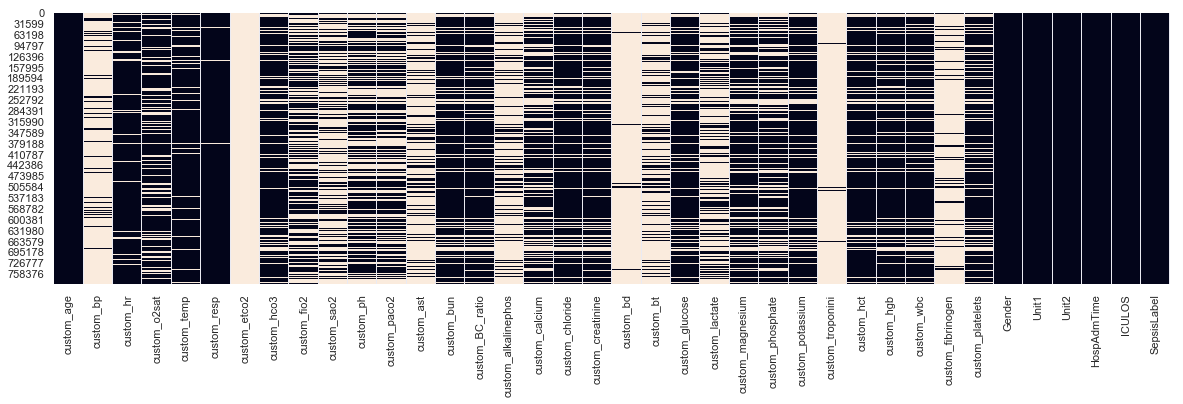

In [3]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(trainA == 'Missing', cbar=False)

In [35]:
lackA = {}
for feature in list(trainA.columns):
    lackA[feature] = len(trainA[trainA[feature] == 'Missing']) / len(trainA[feature])

([<matplotlib.axis.XTick at 0x1a4cfe0be0>,
 <a list of 38 Text xticklabel objects>)

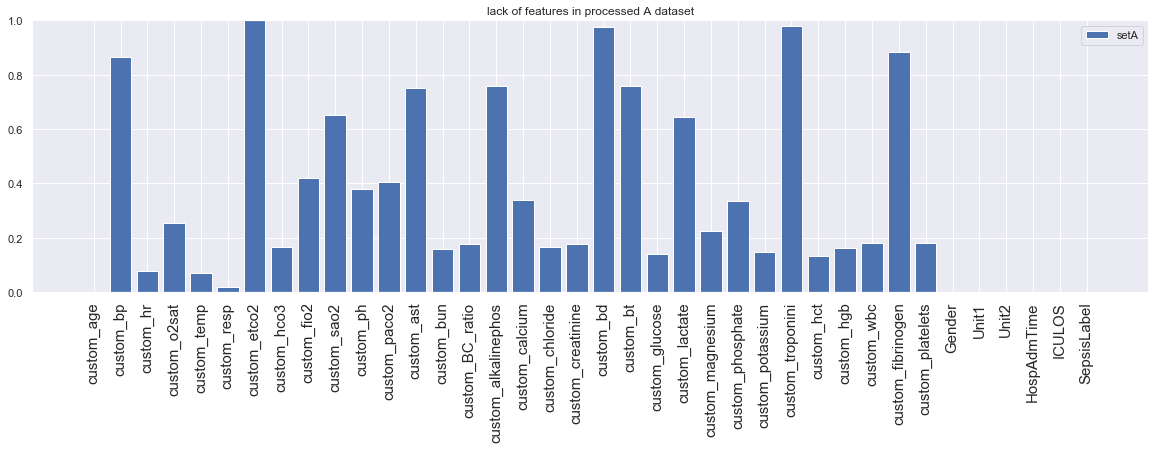

In [65]:
percentage_A = pd.DataFrame.from_dict(lackA, orient='index')
pA = plt.bar(list(trainA.columns), percentage_A[0], label='line')
plt.legend(handles=[pA], labels=['setA'], loc='best')

plt.ylim(ymax=1)
plt.title("lack of features in processed A dataset")
plt.xticks(list(range(len(list(lackA.keys())))), list(lackA.keys()), rotation=90, fontsize=15)

##### B

In [27]:
with open('./data/processedB/trainB_filled.pkl', 'rb') as f:
    trainB = pickle.load(f)

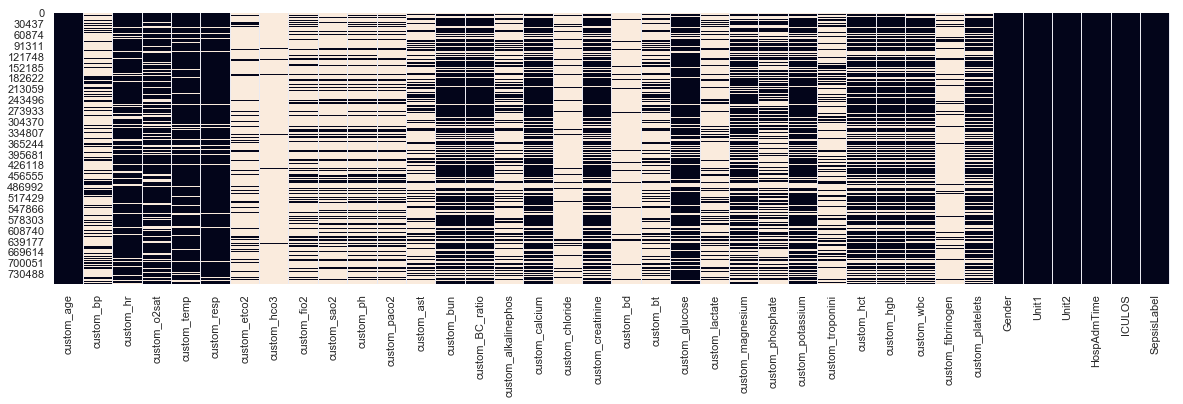

In [18]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(trainB == 'Missing', cbar=False)

In [23]:
lackB = {}
for feature in list(trainB.columns):
    lackB[feature] = len(trainB[trainB[feature] == 'Missing']) / len(trainB[feature])

([<matplotlib.axis.XTick at 0x1a34878908>,
 <a list of 38 Text xticklabel objects>)

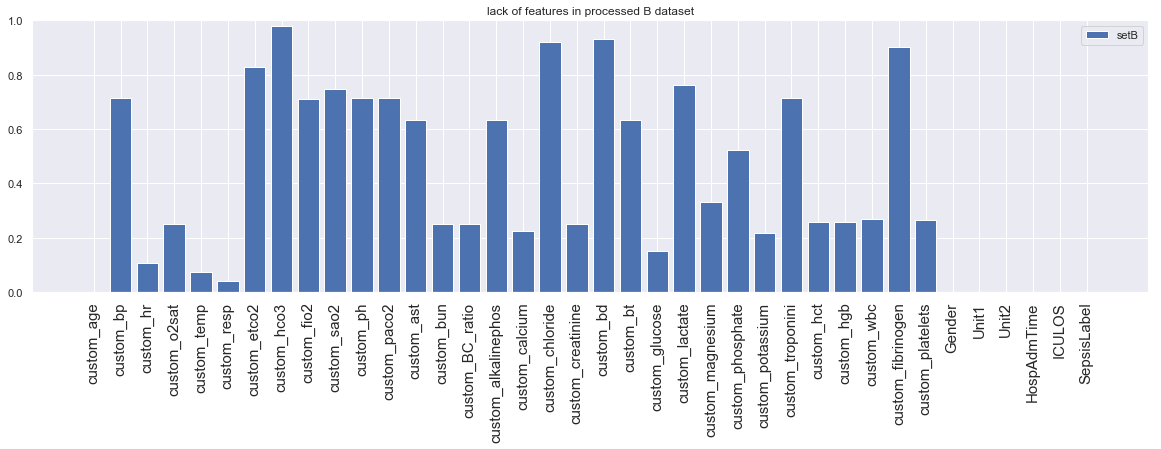

In [66]:
percentage_B = pd.DataFrame.from_dict(lackB, orient='index')
pB = plt.bar(list(trainB.columns), percentage_B[0], label='line')
plt.legend(handles=[pB], labels=['setB'], loc='best')

plt.ylim(ymax=1)
plt.title("lack of features in processed B dataset")
plt.xticks(list(range(len(list(lackB.keys())))), list(lackB.keys()), rotation=90, fontsize=15)

### Multi-Processing(old)

In [54]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
def feature_engineer(train):    
    print('Begin!')
    train = feature_engineer_age(train)
    train = feature_engineer_blood_pressure(train)
    train = feature_engineer_hr(train)
    train = feature_engineer_o2sat(train)
    train = feature_engineer_temp(train)
    train = feature_engineer_resp_rate(train)
    train = feature_engineer_etco2(train)

    train = feature_engineer_baseexcess(train)
    train = feature_engineer_hco3(train)
    train = feature_engineer_fso2(train)
    train = feature_engineer_ph(train)
    train = feature_engineer_paco2(train)
    train = feature_engineer_ast(train)
    train = feature_engineer_bun(train)
    train = feature_engineer_alkalinephos(train)
    train = feature_engineer_calcium(train)
    train = feature_engineer_chloride(train)
    train = feature_engineer_creatinine(train)
    train = feature_engineer_bilirubin(train)
    train = feature_engineer_glucose(train)
    train = feature_engineer_lactate(train)
    train = feature_engineer_magnesium(train)
    train = feature_engineer_phosphate(train)
    train = feature_engineer_potassium(train)
    train = feature_engineer_troponin(train)
    train = feature_engineer_hct(train)
    train = feature_engineer_hgb(train)
    train = feature_engineer_ptt(train)
    train = feature_engineer_wbc(train)
    train = feature_engineer_fibrinogen(train)
    train = feature_engineer_platelets(train)
    train = feature_engineer_unit(train)
    print('Data processed!')
    
    return train


In [78]:
def generate(i):
    with open(f'./data/processedA/trainA_{i}.pkl', 'rb') as file:
        tmp = pickle.load(file)
        tmp = feature_engineer(tmp)
        with open(f"./data/A_single/A_single_{i}.pkl", 'wb') as file:
            pickle.dump(tmp[feature_to_use], file)
            
def main():

    pool = Pool()
    #seed_candidate = list(range(20336))
    seed_candidate = list(range(2890, 2900))
    func = partial(generate, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

EOFError: Ran out of input

In [ ]:
def generate(i):
    with open(f'./data/processedB/trainB_{i}.pkl', 'rb') as file:
        tmp = pickle.load(file)
        tmp = feature_engineer(tmp)
        with open(f"./data/B_single/B_single_{i}.pkl", 'wb') as file:
            pickle.dump(tmp[feature_to_use], file)
            
def main():

    pool = Pool()
    seed_candidate = list(range(20000))
    func = partial(generate, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

### Multi-Processing(new)

In [4]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS', 'SepsisLabel']


In [5]:
def feature_engineer(train):    
    #print('Begin!')
    train = feature_engineer_age(train)
    train = feature_engineer_blood_pressure(train)
    train = feature_engineer_hr(train)
    train = feature_engineer_o2sat(train)
    train = feature_engineer_temp(train)
    train = feature_engineer_resp_rate(train)
    train = feature_engineer_etco2(train)

    train = feature_engineer_baseexcess(train)
    train = feature_engineer_hco3(train)
    train = feature_engineer_fso2(train)
    train = feature_engineer_ph(train)
    train = feature_engineer_paco2(train)
    train = feature_engineer_ast(train)
    train = feature_engineer_bun(train)
    train = feature_engineer_alkalinephos(train)
    train = feature_engineer_calcium(train)
    train = feature_engineer_chloride(train)
    train = feature_engineer_creatinine(train)
    train = feature_engineer_bilirubin(train)
    train = feature_engineer_glucose(train)
    train = feature_engineer_lactate(train)
    train = feature_engineer_magnesium(train)
    train = feature_engineer_phosphate(train)
    train = feature_engineer_potassium(train)
    train = feature_engineer_troponin(train)
    train = feature_engineer_hct(train)
    train = feature_engineer_hgb(train)
    train = feature_engineer_ptt(train)
    train = feature_engineer_wbc(train)
    train = feature_engineer_fibrinogen(train)
    train = feature_engineer_platelets(train)
    train = feature_engineer_unit(train)
    train = feature_engineer_cut(train)
    #print('Data processed!')
    
    return train


In [77]:
def generate(i):
    print(i)
    with open(f'./data/processedA/trainA_{i}.pkl', 'rb') as file:
        tmp = pickle.load(file)
        tmp = feature_engineer(tmp)
        
        with open(f"./data/A_cut/A_cut_{i}.pkl", 'wb') as file:
            pickle.dump(tmp[feature_to_use], file)
            
def main():

    pool = Pool()
    seed_candidate = list(range(20336))
    #seed_candidate = list(range(2890,2900))
    func = partial(generate, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

2890
2892
2893
2896
2895
2891
2897
2899
2894
2898


EOFError: Ran out of input

In [14]:
def generate(i):
    print(i)
    with open(f'./data/processedB/trainB_{i}.pkl', 'rb') as file:
        tmp = pickle.load(file)
        tmp = feature_engineer(tmp)
        
        with open(f"./data/B_cut/B_cut_{i}.pkl", 'wb') as file:
            pickle.dump(tmp[feature_to_use], file)
            
def main():
    pool = Pool()
    seed_candidate = list(range(20000))
    func = partial(generate, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

0
1251
834
417
1668
2085
2502
3336
3753
2919
4170
4587
418
4171
1669
3337
1252
1
2086
835
2920
3754
2503
4588
4172
419
836
1253
2
3338
1670
2087
2921
3755
2504
4589
4173
420
3339
1254
837
2922
1671
3756
2088
3
4590
2505
4174
421
3340
1255
2923
838
4
2506
3757
1672
2089
4591
4175
1256
2924
422
3341
5
839
1673
2090
4592
2507
3758
4176
1257
2925
840
423
3342
6
2091
2508
1674
4593
3759
1258
4177
424
7
841
2926
3343
1675
2092
2509
3760
4594
1259
4178
425
2927
842
8
3344
2093
1676
3761
2510
4595
843
426
1260
9
4179
2928
3345
2094
1677
3762
2511
4596
844
1261
427
4180
3346
2929
10
4597
1678
2095
2512
3763
845
2930
11
1262
4181
3347
428
1679
4598
2096
2513
3764
846
3348
2931
4182
1263
12
429
2097
4599
1680
3765
2514
847
430
4183
3349
2932
13
1264
2098
3766
1681
4600
2515
848
1265
431
2933
4184
3350
14
2099
3767
1682
4601
2516
1266
849
2934
4185
432
2100
3351
15
3768
1683
4602
2517
850
1267
433
4186
2935
2101
3769
3352
16
1684
4603
2518
851
1268
434
2936
4187
2102
17
3770
3353
1685
4604
2519
85

4732
3898
3065
2647
1813
3482
563
146
980
2231
4317
1397
4733
3483
3066
3899
2648
1814
147
564
4318
981
2232
1398
4734
3484
3067
3900
565
2649
1815
148
2233
4319
982
1399
4735
3485
3068
3901
983
1816
566
2650
149
2234
4320
1400
4736
3902
3069
984
3486
150
1817
567
2651
2235
4321
1401
4737
3903
3070
985
3487
568
151
1818
2652
2236
4322
1402
4738
3904
569
3071
986
3488
152
1819
2237
2653
4323
1403
4739
3905
570
987
3489
3072
1820
153
2238
2654
4324
1404
4740
571
3906
988
3490
3073
1821
2239
154
2655
4325
1405
4741
3907
572
989
1822
3074
3491
2240
155
4326
2656
1406
4742
3908
573
1823
990
3492
3075
156
2657
4327
2241
1407
4743
991
3909
1824
574
3076
2658
157
3493
4328
2242
1408
4744
3910
992
1825
575
3077
158
2659
3494
4329
2243
1409
4745
3911
576
993
1826
3078
159
2660
2244
4330
3495
1410
4746
994
3912
577
1827
160
3079
2661
2245
3496
4331
1411
4747
3913
578
995
1828
161
3080
2662
3497
2246
4332
1412
4748
996
3914
579
162
1829
3081
2663
2247
3498
4333
1413
4749
997
580
3915
1830
2248
349

1122
1539
3207
4874
287
705
3624
1954
4458
2373
2788
4040
1123
1540
3208
4875
3625
288
706
4459
1955
2374
2789
4041
1124
3209
1541
4876
3626
289
707
4460
1956
2375
2790
4042
1125
3210
1542
4877
3627
708
290
4461
1957
2376
3211
2791
4043
1126
1543
4878
709
3628
291
1958
4462
2377
3212
2792
4044
1127
1544
4879
710
3629
292
1959
4463
3213
2378
4045
2793
1128
1545
4880
711
3630
293
4464
1960
3214
2379
4046
2794
1129
1546
4881
3631
712
1961
294
4465
3215
2380
2795
4047
1130
4882
713
1547
3632
1962
4466
295
2381
3216
2796
4048
1131
1548
4883
714
3633
1963
296
4467
2382
3217
2797
4049
715
1132
4884
1549
3634
1964
297
4468
3218
2383
2798
4050
716
1133
1550
3635
4885
4469
1965
298
3219
2799
2384
4051
717
1134
3636
1551
4886
1966
4470
299
3220
2385
2800
4052
718
4887
1552
1135
3637
1967
300
4471
3221
2386
4053
2801
4888
719
1553
3638
1136
1968
301
4472
2387
3222
2802
4054
4889
720
1554
1137
3639
1969
4473
302
2388
3223
2803
4055
721
4890
1555
1138
1970
3640
4474
303
2389
3224
2804
4056
722
4891


7934
7100
8351
9600
5017
6267
5433
5850
8768
6684
9184
7518
7935
7101
5018
8352
5434
5851
9601
6268
8769
6685
9185
7519
7936
7102
5019
8353
5852
6269
9602
5435
8770
9186
6686
7520
7937
6270
7103
5020
5853
8354
5436
9603
8771
9187
7521
6687
6271
5021
7938
7104
5854
8355
5437
9604
8772
9188
6688
6272
7522
5022
7939
7105
5855
5438
8356
9605
8773
6273
9189
6689
5023
7523
7940
5856
7106
5439
8357
9606
8774
6274
5024
9190
6690
7524
7941
5857
7107
8358
5440
9607
8775
6275
6691
5025
7942
9191
7525
5858
7108
9608
8359
5441
6276
8776
5026
6692
7526
7943
9192
5859
7109
9609
8360
5442
8777
6277
5860
5027
7527
7944
6693
9193
7110
8361
9610
5443
6278
8778
5861
5028
7528
7945
9194
6694
7111
9611
8362
5444
6279
8779
5862
5029
9195
7946
6695
7529
7112
8363
9612
6280
5445
8780
5863
5030
6696
9196
7530
7113
7947
8364
6281
9613
5446
8781
5864
5031
6697
9197
7114
7531
7948
6282
9614
8365
5447
8782
5865
5032
9198
6698
7949
7115
7532
6283
9615
8366
5448
8783
9199
5866
5033
7116
7950
6699
7533
6284
8367
9616


8904
5154
8070
8488
9736
6405
9321
7654
5987
6820
7237
5569
8905
8071
5155
8489
9737
5988
7655
9322
6406
6821
7238
5156
8906
5570
8072
7656
8490
9738
5989
6407
9323
6822
7239
8907
5157
5571
8073
7657
9739
8491
5990
6408
7240
9324
6823
5158
8908
5572
8074
7658
9325
5991
9740
8492
7241
6409
6824
5159
8909
5573
8075
7659
9326
8493
7242
5992
9741
6410
6825
5160
8910
5574
8076
7660
8494
7243
9327
9742
5993
6411
6826
5161
8911
8077
5575
7661
9328
8495
7244
9743
5994
6412
8912
6827
5162
8078
5576
7662
8496
9329
9744
7245
6413
5995
8913
6828
5163
8079
5577
7663
8497
9330
9745
6414
5996
7246
6829
8914
5164
8080
5578
7664
8498
9331
9746
6415
7247
5997
6830
8915
5165
8081
5579
8499
7665
9332
9747
6416
7248
5998
6831
8916
5166
8082
5580
8500
7666
9333
6417
9748
5999
7249
6832
5167
8917
8083
5581
8501
7667
9334
7250
6418
9749
6000
6833
5168
8918
8084
5582
9335
8502
7668
6419
9750
7251
6001
6834
5169
8919
8085
5583
9336
8503
7669
6420
7252
9751
6002
6835
5170
8920
8086
5584
9337
8504
7670
9752
6421


6123
7373
9872
8625
9041
6541
9458
7790
5705
6957
5291
8208
6124
9873
7374
8626
9042
6542
9459
7791
6958
5706
5292
6125
8209
9874
7375
8627
9043
6543
7792
9460
6959
5707
5293
8210
6126
9875
7376
8628
6544
9044
9461
5708
7793
6960
5294
8211
6127
7377
9876
8629
6545
9045
7794
5709
9462
6961
8212
6128
5295
7378
8630
9877
7795
6546
9046
5710
6962
9463
8213
6129
7379
5296
8631
9878
7796
6547
9047
5711
9464
6963
6130
8214
5297
7380
8632
9879
7797
5712
6548
9048
9465
6964
6131
8215
5298
7381
8633
9880
7798
9049
6549
9466
5713
6965
8216
6132
5299
7382
8634
9881
7799
9050
5714
6550
9467
6966
8217
6133
5300
8635
7383
9882
7800
9051
6551
5715
9468
6967
8218
6134
5301
9883
8636
7384
6552
7801
9052
5716
9469
6968
8219
6135
5302
8637
9884
7385
6553
7802
5717
9053
9470
6969
5303
8220
6136
8638
9885
7386
6554
7803
9471
9054
5718
6970
5304
8221
6137
9886
8639
7387
6555
7804
9472
9055
5719
6971
5305
8222
6138
8640
9887
7388
6556
7805
9473
9056
5720
6972
5306
8223
6139
8641
9888
7389
9474
6557
9057
7806


13763
14595
14179
12097
11263
10013
10430
12930
13347
11681
12513
10847
13764
14596
11264
14180
12098
10014
10431
12931
12514
13348
11682
10848
14597
13765
11265
12099
10015
14181
10432
12932
13349
12515
11683
10849
14598
13766
12100
11266
14182
10016
10433
12933
13350
11684
12516
10850
12101
14599
13767
11267
14183
10017
10434
12934
13351
12517
11685
10851
12102
14600
11268
13768
14184
10018
10435
12935
13352
12518
11686
10852
12103
14601
14185
11269
13769
10019
10436
12936
13353
12519
11687
10853
12104
14602
11270
14186
13770
10020
10437
12937
13354
11688
12520
10854
12105
13771
14603
11271
14187
10438
10021
12938
13355
11689
12521
10855
13772
12106
11272
14604
14188
10439
10022
12939
13356
11690
12522
11273
10856
14605
13773
12107
14189
10440
10023
12940
13357
11691
10857
12523
13774
14606
11274
12108
14190
10441
10024
11692
12941
13358
14607
12524
10858
13775
12109
14191
10442
10025
11275
11693
12942
13359
12525
14608
13776
10859
12110
14192
11276
10026
10443
11694
12943
13360
1460

12626
12211
14293
10544
14710
10127
13043
11377
13460
13877
10960
12627
11796
12212
14294
10545
14711
13044
10128
11378
13461
13878
10961
11797
12628
12213
10546
14295
10129
14712
13045
11379
13462
13879
10962
11798
12629
14296
10547
12214
14713
13046
11380
13463
10130
13880
10963
12630
14297
11799
12215
10548
14714
13047
13464
11381
10131
13881
10964
10549
11800
12631
12216
14298
14715
13048
13465
11382
10132
13882
10965
10550
11801
12632
12217
14299
14716
13049
13466
11383
13883
10133
10966
10551
11802
12633
14300
12218
14717
13050
13467
11384
10134
13884
10967
10552
12634
14301
11803
12219
14718
13468
13051
11385
10135
13885
10968
10553
11804
12635
12220
14302
13052
14719
13469
11386
10969
10136
13886
10554
14720
11805
14303
12221
12636
13053
13470
11387
10970
10137
13887
10555
14721
11806
12637
12222
14304
13054
13471
11388
10138
10971
13888
11807
10556
12638
14722
14305
12223
13055
13472
11389
10972
10139
13889
11808
10557
12639
14723
14306
13056
12224
13473
11390
10973
13890
1014

10240
14407
14823
11074
10659
12740
13573
13156
11491
12326
13991
11910
10241
14824
11075
14408
12741
10660
13574
13157
11492
12327
13992
11911
10242
12742
14825
14409
10661
11076
13158
13575
11493
13993
12328
11912
10243
14826
14410
11077
10662
12743
13576
11494
13159
12329
13994
11913
10244
14827
14411
12744
11078
10663
13577
13160
11495
11914
12330
13995
10245
11079
14412
14828
12745
10664
13578
11496
13161
12331
13996
11915
10246
11080
14413
14829
10665
12746
11497
13579
13162
13997
12332
11916
10247
11081
14414
14830
12747
10666
11498
13580
13163
11917
10248
13998
12333
11082
14415
14831
12748
10667
13581
13164
11499
11918
10249
13999
12334
11083
14416
14832
12749
10668
13582
11500
13165
11919
10250
12335
14000
11084
14417
14833
12750
10669
13583
11501
13166
10251
14001
12336
11920
11085
14418
14834
12751
11502
10670
13584
13167
14002
10252
12337
11921
11086
14419
11503
12752
10671
14835
13585
13168
12338
14003
10253
11922
11087
14420
11504
10672
12753
14836
13586
13169
14004
1025

14936
13270
12024
11189
13686
12439
10354
11605
14103
14521
10774
12855
14937
12025
13271
11190
13687
12440
10355
11606
14104
14522
10775
12856
14938
12026
13272
11191
12441
13688
10356
11607
14105
14523
10776
12857
14939
12027
13273
11192
13689
12442
11608
10357
14524
10777
14106
14940
12858
13274
12028
13690
11193
11609
12443
10358
14525
10778
14107
14941
12859
13691
12029
13275
11610
12444
11194
14526
10359
10779
14108
14942
12030
12860
13692
13276
11611
12445
11195
14527
10360
10780
14109
14943
12031
12861
13693
13277
12446
11612
11196
14528
10361
10781
14110
14944
12032
12862
13694
13278
11613
12447
11197
10362
14529
10782
14111
14945
12033
12863
13695
13279
11614
12448
11198
10363
14530
10783
14946
14112
12034
12864
13280
13696
11615
12449
11199
10364
14531
10784
14947
14113
12035
12865
13281
11616
12450
13697
10365
11200
14532
10785
14948
14114
12036
12866
13282
12451
11617
13698
10366
11201
14533
10786
14115
14949
12037
12867
13283
12452
11618
13699
11202
10367
14534
10787
1411

17140
15057
15890
19637
17971
19220
18388
16723
16307
18804
17555
15474
17141
15891
15058
19638
17972
19221
16308
18389
16724
18805
17556
15475
17142
15892
15059
19639
17973
19222
18390
16309
16725
18806
17557
15476
17143
15893
19640
15060
16310
17974
19223
18391
16726
18807
17558
17144
15477
15894
19641
15061
16311
17975
19224
18392
16727
18808
17559
17145
15478
19642
15895
15062
16312
17976
19225
18393
18809
16728
17560
17146
15479
15896
15063
19643
16313
17977
18394
18810
16729
19226
17561
17147
15064
19644
15480
15897
17978
16314
18395
18811
16730
19227
17562
17148
15065
19645
15481
16315
15898
17979
18396
18812
16731
19228
17563
17149
15066
19646
15899
16316
15482
17980
18397
18813
16732
19229
17564
17150
19647
15067
15483
17981
16317
15900
18398
18814
16733
19230
17565
19648
17151
15068
17982
15484
18399
16318
15901
16734
18815
17566
19231
19649
17152
15069
17983
15485
16319
18400
15902
16735
18816
17567
19232
19650
17153
15070
17984
15486
15903
18401
16320
16736
17568
18817
1923

16837
15587
16003
17255
18917
18502
19751
18085
19333
16421
15172
17669
16838
16004
15588
17256
18503
19752
18918
18086
16422
19334
15173
17670
16839
15589
16005
17257
18504
19753
18919
18087
16423
15174
19335
17671
16006
16840
15590
17258
18505
18920
19754
18088
16424
15175
19336
17672
16007
16841
15591
17259
18506
18921
19755
18089
16425
19337
17673
15176
16008
16842
15592
17260
19756
18922
18507
18090
16426
19338
17674
15177
16009
16843
15593
17261
18091
18923
19757
18508
19339
16427
15178
17675
16010
16844
15594
17262
18924
18509
18092
19758
16428
19340
15179
17676
16011
15595
16845
17263
18510
18925
18093
19759
16429
17677
19341
15180
16012
16846
15596
17264
18926
18511
18094
19760
16430
17678
15181
16013
16847
19342
15597
17265
18927
19761
18512
18095
16431
17679
15182
15598
16014
16848
19343
18928
18513
17266
18096
19762
16432
17680
15183
16849
15599
16015
19344
18514
18929
17267
16433
19763
18097
16850
17681
15184
15600
19345
16016
18515
18930
17268
16434
19764
18098
16851
1768

16116
18615
15285
16951
19865
17369
15702
19031
18199
17783
16535
16117
19447
18616
15286
16952
19866
17370
19032
15703
18200
17784
18617
16536
19448
16118
15287
16953
19867
17371
18618
15704
19033
18201
16537
17785
16119
19449
15288
16954
15705
17372
19868
19034
18202
18619
16538
17786
16120
19450
15289
16955
15706
17373
19869
19035
18203
16539
18620
17787
15290
16121
19451
16956
15707
17374
19870
19036
17788
18204
16540
18621
15291
16122
19452
15708
16957
17375
19037
19871
18622
17789
18205
16541
15292
19453
16123
16958
15709
19038
19872
17376
18206
18623
17790
16542
16124
15293
19454
15710
16959
17377
19039
19873
18624
18207
17791
16543
15294
16125
19455
15711
16960
19040
17378
19874
18625
17792
18208
16544
15295
16126
19456
16961
15712
17379
19041
19875
17793
18626
18209
16545
16127
15296
19457
16962
15713
19876
17380
19042
18627
17794
18210
16128
16546
15297
19458
16963
15714
17381
19877
19043
17795
18628
18211
16129
16547
15298
19459
16964
15715
19878
17382
19044
17796
18212
1862

16230
18312
15400
16648
15816
19560
17065
19145
19978
17897
17484
18313
16231
15401
18729
16649
15817
19561
17066
19146
19979
17898
16232
18314
17485
18730
15402
15818
16650
19562
17067
19147
17899
19980
15403
16233
18315
17486
18731
15819
16651
19563
17068
19148
19981
17900
16234
15404
18316
17487
18732
15820
16652
19564
17069
19149
16235
17901
15405
19982
18317
17488
18733
15821
16653
19565
17070
17902
19150
16236
18318
19983
15406
18734
17489
15822
16654
17903
17071
19566
19151
16237
19984
18319
15407
18735
17490
16655
15823
17072
17904
19567
19152
16238
18320
19985
15408
18736
17491
16656
15824
17073
17905
19153
19568
18321
16239
19986
18737
17492
15409
15825
16657
17906
17074
19154
18322
19569
19987
16240
18738
15410
17493
16658
15826
17907
17075
19155
18323
16241
19570
18739
19988
15411
17494
16659
15827
17908
19156
17076
18740
16242
18324
19571
19989
15412
17495
16660
15828
17909
19157
17077
18741
18325
16243
15413
19990
15829
19572
16661
17496
17910
19158
17078
18326
15414
1874

In [128]:
# fix 0 bytes files generated
def generate1(fix_list):
    for i in tqdm(fix_list):
        with open(f'./data/processedA/trainA_{i}.pkl', 'rb') as file:
            tmp = pickle.load(file)
            tmp = feature_engineer(tmp)
            with open(f"./data/A_single/A_single_{i}.pkl", 'wb') as file:
                pickle.dump(tmp[feature_to_use], file)

def generate2(fix_list):
    for i in tqdm(fix_list):
        try:
            with open(f'./data/processedA/trainA_{i}.pkl', 'rb') as file:
                tmp = pickle.load(file)
                tmp = feature_engineer(tmp)
            with open(f"./data/A_cut/A_cut_{i}.pkl", 'wb') as file:
                pickle.dump(tmp[feature_to_use], file)
        except:
            print(i)
        
                    
def get_number(path):
    for i in range(len(path)):
        name = ''
        for char in path[i]:
            if char.isdigit():
                name += char
        if len(name) == 0:
            print(path[i])
            continue
        else:
            path[i] = name
    return path
    
def fix_data():
    
    # processed ➡️ single 
    # processed ➡️ cut
    cut = get_number(listdir('./data/A_cut/'))
    processed = get_number(listdir('./data/processedA/'))
    
    processed.remove('trainA_filled.pkl')
    processed.remove('trainA.pkl')
    while '.DS_Store' in processed:
        processed.remove('.DS_Store')
        
    single = get_number(listdir('./data/A_single/'))
    print(len(cut), len(processed), len(single))
    fix1 = list(set(processed).difference(set(single)))
    fix2 = list(set(processed).difference(set(cut)))
    generate1(fix1)
    generate2(fix2)
    
#     cut = listdir('./data/B_cut/')
#     processed = listdir('./data/processedB/')
#     single = listdir('./data/B_single/')
#     fix1 = list(set(processed).difference(set(single)))
#     fix2 = list(set(processed).difference(set(cut)))
#     generate1(fix1)
#     generate2(fix2)
fix_data()



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

trainA_filled.pkl
.DS_Store
trainA.pkl
.DS_Store
20335 20336 20337




100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

# Classification

### one-hot

In [13]:
with open('./data/processedA/trainA_filled.pkl', 'rb') as f:
    train = pickle.load(f)

In [4]:
encoder = LabelEncoder()
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
# custom = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
#                  'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
#                  'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
                 'custom_paco2', 'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
for c in tqdm(custom):
    train[c][0:len(train[c])] = encoder.fit_transform(train[c][0:len(train[c])])


100%|██████████| 26/26 [00:12<00:00,  3.71it/s]


In [33]:
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
                 'custom_paco2', 'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime']
encoded_x = None
for f in custom:
    print(f)
    enc = OneHotEncoder()
    fff = train[f].to_numpy().reshape(train[f].shape[0], 1)
    enc.fit(fff)
    array = enc.transform(fff).toarray()
    if encoded_x is None:
        encoded_x = array
    else:
        encoded_x = np.concatenate((encoded_x, array), axis=1)
    

custom_age
custom_hr
custom_o2sat
custom_temp
custom_resp
custom_hco3
custom_fio2
custom_ph
custom_paco2
custom_bun
custom_BC_ratio
custom_calcium
custom_chloride
custom_creatinine
custom_glucose
custom_magnesium
custom_phosphate
custom_potassium
custom_hct
custom_hgb
custom_wbc
custom_platelets
Gender
Unit
HospAdmTime


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [40]:
#vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
                 'custom_paco2', 'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime']
# 导入数据
data = train
flag = train

# 训练集和测试集
data_1 = pd.DataFrame(encoded_x[train['SepsisLabel'] == 1])
data_0 = pd.DataFrame(encoded_x[train['SepsisLabel'] == 0])
flag_1 = train[train['SepsisLabel'] == 1]['SepsisLabel']
flag_0 = train[train['SepsisLabel'] == 0]['SepsisLabel']

np.random.seed(seed=3)
data_0 = data_0.sample(len(data_1),replace=False)
flag_0 = flag_0.sample(len(data_1),replace=False)
data = data_1.append(data_0)
flag = flag_1.append(flag_0)
train_x, test_x, train_y, test_y = train_test_split(
    data, 
    flag, 
    test_size=0.3,
    random_state=0, 
    stratify=flag ## 这里保证分割后y的比例分布与原数据一致
)


### 不带one-hot

In [89]:
with open('./data/processedA/trainA_filled.pkl', 'rb') as f:
    train = pickle.load(f)

In [90]:
encoder = LabelEncoder()
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
# custom = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
#                  'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
#                  'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
# custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
#                  'custom_paco2', 'custom_bun', 'custom_BC_ratio',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine',
#                  'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_hct', 'custom_hgb', 'custom_wbc', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_ph',
                  'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
for c in tqdm(custom):
    train[c][0:len(train[c])] = encoder.fit_transform(train[c][0:len(train[c])])

scaler = MinMaxScaler(feature_range=(0, 1))
train[custom] = scaler.fit_transform(train[custom])

    

100%|██████████| 24/24 [00:12<00:00,  3.82it/s]


In [91]:
#vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
# custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
#                  'custom_paco2', 'custom_bun', 'custom_BC_ratio',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine',
#                  'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_hct', 'custom_hgb', 'custom_wbc', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
# 导入数据
data = train
flag = train

# 训练集和测试集
data_1 = train[train['SepsisLabel'] == 1][custom]
data_0 = train[train['SepsisLabel'] == 0][custom]
flag_1 = train[train['SepsisLabel'] == 1]['SepsisLabel'] # todo
flag_0 = train[train['SepsisLabel'] == 0]['SepsisLabel']

np.random.seed(seed=3)
data_0 = data_0.sample(len(data_1),replace=False)
flag_0 = flag_0.sample(len(data_1),replace=False)
data = data_1.append(data_0)
flag = flag_1.append(flag_0)
train_x, test_x, train_y, test_y = train_test_split(
    data, 
    flag, 
    test_size=0.3,
    random_state=0, 
    stratify=flag ## 这里保证分割后y的比例分布与原数据一致
)


### XGBOOST

In [201]:
def custom_loss(y_pre,D_label): #别人的自定义损失函数
    label=D_label.get_label()
    penalty=2.0
    grad=-label/y_pre+penalty*(1-label)/(1-y_pre) #梯度
    hess=label/(y_pre**2)+penalty*(1-label)/(1-y_pre)**2 #2阶导
    return grad,hess


SyntaxError: invalid character in identifier (<ipython-input-201-3573965e7820>, line 2)

[0]	train-auc:0.775346
[1]	train-auc:0.796177
[2]	train-auc:0.799475
[3]	train-auc:0.801946
[4]	train-auc:0.808389
[5]	train-auc:0.808129
[6]	train-auc:0.810929
[7]	train-auc:0.812178
[8]	train-auc:0.813441
[9]	train-auc:0.813773
[10]	train-auc:0.814256
[11]	train-auc:0.814139
[12]	train-auc:0.814373
[13]	train-auc:0.814294
[14]	train-auc:0.814251
[15]	train-auc:0.814593
[16]	train-auc:0.814805
[17]	train-auc:0.814893
[18]	train-auc:0.815962
[19]	train-auc:0.816485
[20]	train-auc:0.816492
[21]	train-auc:0.816797
[22]	train-auc:0.81709
[23]	train-auc:0.817131
[24]	train-auc:0.817086
[25]	train-auc:0.817227
[26]	train-auc:0.816932
[27]	train-auc:0.817383
[28]	train-auc:0.817676
[29]	train-auc:0.817998
[30]	train-auc:0.817984
[31]	train-auc:0.818046
[32]	train-auc:0.818438
[33]	train-auc:0.818318
[34]	train-auc:0.818293
[35]	train-auc:0.818128
[36]	train-auc:0.818646
[37]	train-auc:0.818605
[38]	train-auc:0.818672
[39]	train-auc:0.818767
[40]	train-auc:0.818953
[41]	train-auc:0.819194
[42

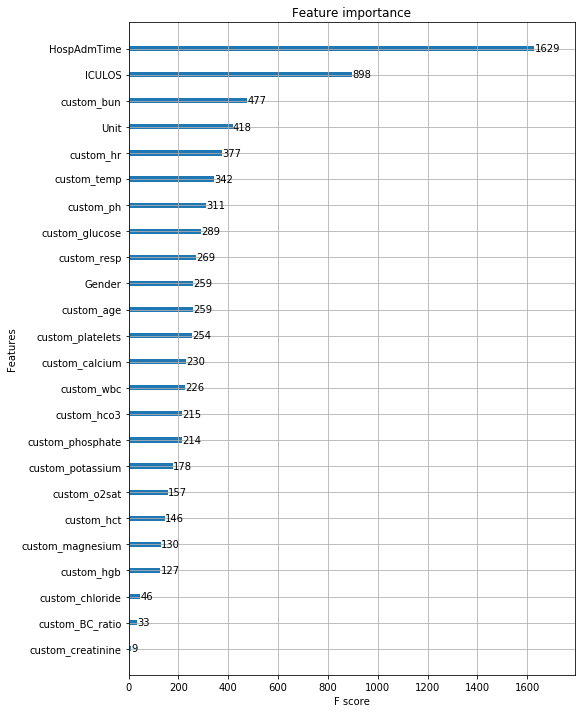

In [92]:
# 模型初始化设置
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x)

# booster:
params = {'booster': 'gbtree',
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'max_depth': 7,
          'lambda': 15,
          'subsample': 0.75,
          'colsample_bytree': 0.75,
          'min_child_weight': 1,
          'eta': 0.025,
          'seed': 0,
          'nthread': 8,
          'silent': 1,
          'gamma': 0.15,
          'learning_rate': 0.01}

watchlist = [(dtrain, 'train')]

# 建模与预测:NUM_BOOST_round迭代次数和数的个数一致
bst = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist,) #obj=custom_loss, maximize=False)
now = int(round(time.time()*1000))
NOW = time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(now/1000))
bst.save_model(f'xgb_{NOW}.model')

ypred = bst.predict(dtest)

# 设置阈值, 输出一些评价指标，>0.5预测为1，其他预测为0
y_pred = (ypred >= 0.47)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))
metrics.confusion_matrix(test_y, y_pred)


mpl.rcParams['font.sans-serif'] = ['SimHei']
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(8, 12)

In [9]:
for t in range(10,100):
    y_pred = (ypred >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
    print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))

0.1
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.11
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.12
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.13
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.14
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.15
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.16
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.17
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.18
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.19
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.2
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.21
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.22
AUC: 0.8122
ACC: 0.5000
Recall: 1.0000
F1-score: 

In [10]:
y_pred = bst.predict(dtest)
y_pred = (ypred >= 0.44)*1
df = pd.DataFrame(y_pred, columns = ['0'])


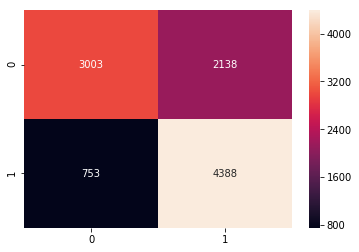

In [11]:
conf_matrix = confusion_matrix(pd.DataFrame(test_y)['SepsisLabel'], df['0'])
sns.heatmap(conf_matrix, annot=True, fmt="d");

### LGBM

Start training...
[1]	valid_0's auc: 0.73541	valid_0's binary_logloss: 0.673683
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.750084	valid_0's binary_logloss: 0.658468
[3]	valid_0's auc: 0.776011	valid_0's binary_logloss: 0.643324
[4]	valid_0's auc: 0.777863	valid_0's binary_logloss: 0.630795
[5]	valid_0's auc: 0.780368	valid_0's binary_logloss: 0.621615
[6]	valid_0's auc: 0.7825	valid_0's binary_logloss: 0.612192
[7]	valid_0's auc: 0.7815	valid_0's binary_logloss: 0.6051
[8]	valid_0's auc: 0.780756	valid_0's binary_logloss: 0.599132
[9]	valid_0's auc: 0.784234	valid_0's binary_logloss: 0.592895
[10]	valid_0's auc: 0.786723	valid_0's binary_logloss: 0.587952
[11]	valid_0's auc: 0.787763	valid_0's binary_logloss: 0.584381
[12]	valid_0's auc: 0.789202	valid_0's binary_logloss: 0.580489
[13]	valid_0's auc: 0.79031	valid_0's binary_logloss: 0.577333
[14]	valid_0's auc: 0.791894	valid_0's binary_logloss: 0.574489
[15]	valid_0's auc: 0.794234	valid_0's b

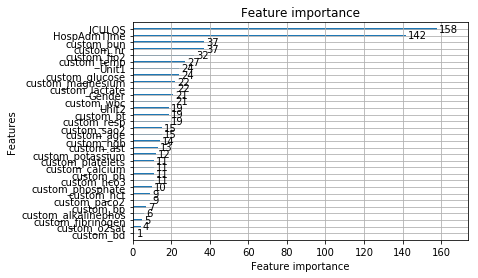

In [210]:
test_X, val_x, test_Y, val_y = train_test_split(
    test_x, 
    test_y, 
    test_size=0.25,
    random_state=0, 
    stratify=test_y ## 这里保证分割后y的比例分布与原数据一致
)

X_train = train_x
y_train = train_y

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)


# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 5,
    'max_depth': 6,
    'min_data_in_leaf': 450,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'lambda_l1': 1,  
    'lambda_l2': 0.001,  # 越小l2正则程度越高
    'min_gain_to_split': 0.2,
    'verbose': 5,
    'is_unbalance': True
}
 
# train
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)
 
print('Start predicting...')
 
preds = gbm.predict(test_X, num_iteration=gbm.best_iteration)  # 输出的是概率


y_pred = (preds >= 0.36)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))
metrics.confusion_matrix(test_Y, y_pred)

# 绘制特征重要性

lgb.plot_importance(gbm)

In [211]:
for t in range(10,100):
    y_pred = (preds >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
    print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))

0.1
AUC: 0.5298
ACC: 0.5299
Recall: 0.9984
F1-score: 0.6799
Precesion: 0.5155
0.11
AUC: 0.5387
ACC: 0.5387
Recall: 0.9971
F1-score: 0.6837
Precesion: 0.5202
0.12
AUC: 0.5477
ACC: 0.5478
Recall: 0.9953
F1-score: 0.6876
Precesion: 0.5252
0.13
AUC: 0.5568
ACC: 0.5569
Recall: 0.9938
F1-score: 0.6916
Precesion: 0.5304
0.14
AUC: 0.5663
ACC: 0.5663
Recall: 0.9912
F1-score: 0.6957
Precesion: 0.5359
0.15
AUC: 0.5735
ACC: 0.5736
Recall: 0.9888
F1-score: 0.6987
Precesion: 0.5402
0.16
AUC: 0.5838
ACC: 0.5838
Recall: 0.9860
F1-score: 0.7032
Precesion: 0.5465
0.17
AUC: 0.5927
ACC: 0.5928
Recall: 0.9839
F1-score: 0.7073
Precesion: 0.5521
0.18
AUC: 0.6019
ACC: 0.6020
Recall: 0.9816
F1-score: 0.7115
Precesion: 0.5580
0.19
AUC: 0.6118
ACC: 0.6119
Recall: 0.9774
F1-score: 0.7158
Precesion: 0.5646
0.2
AUC: 0.6217
ACC: 0.6217
Recall: 0.9730
F1-score: 0.7201
Precesion: 0.5715
0.21
AUC: 0.6296
ACC: 0.6296
Recall: 0.9694
F1-score: 0.7236
Precesion: 0.5772
0.22
AUC: 0.6405
ACC: 0.6405
Recall: 0.9663
F1-score: 

### Test Example for XGBOOST

In [95]:
!ls

A_group.csv                       reference
B_group.csv                       xgb_2019-07-17-14-05-28.model
Data_Preprocessing.ipynb          xgb_2019-07-17-14-18-07.model
EDA_and_Baseline.ipynb            xgb_2019-07-18-10-14-55.model
Feature_Engineering.ipynb         xgb_2019-07-18-10-34-18.model
PRSA_data_2010.1.1-2014.12.31.csv xgb_2019-07-18-10-35-03.model
README.md                         xgb_2019-07-18-10-35-34.model
data                              xgb_2019-07-18-10-45-43.model
data_analysis_images              xgb_2019-07-18-10-47-32.model
evaluate_sepsis_score.py          xgb_2019-07-18-10-47-42.model
kw.ipynb                          xgb_2019-07-18-10-47-53.model
others'works                      xgb_2019-07-22-09-58-17.model
pollution.csv                     xgb_2019-07-23-14-24-05.model
python-example-2019


In [96]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_sao2', 'custom_ph',
                  'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']
bst2 = xgb.Booster(model_file='xgb_2019-07-23-14-24-05.model') 

def test(csv, bst2):
    #csv = 'p108230.psv'
    cur_train = pd.read_csv(f'./data/trainingB/' + csv, sep='|')
    cur_train = cur_train.fillna(method='pad')
    cur_train = feature_engineer(cur_train)[feature_to_use]

    encoder = LabelEncoder()
    custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                     'custom_resp', 'custom_hco3', 'custom_ph',
                     'custom_bun', 'custom_BC_ratio',
                     'custom_calcium', 'custom_chloride', 'custom_creatinine',
                     'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                     'custom_hct', 'custom_hgb', 'custom_wbc', 
                      'custom_platelets', 'Gender', 'Unit', 'HospAdmTime']

    for c in tqdm(custom):
        cur_train[c][0:len(cur_train[c])] = encoder.fit_transform(cur_train[c][0:len(cur_train[c])])
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    cur_train[custom] = scaler.fit_transform(cur_train[custom])
    
    encoded_x = None
    for f in custom:
        #print(f)
        enc = OneHotEncoder()
        fff = cur_train[f].to_numpy().reshape(cur_train[f].shape[0], 1)
        enc.fit(fff)
        array = enc.transform(fff).toarray()
        if encoded_x is None:
            encoded_x = array
        else:
            encoded_x = np.concatenate((encoded_x, array), axis=1)


    dtest = xgb.DMatrix(cur_train[custom])
    preds = bst2.predict(dtest)
    #print(preds)
    return preds, cur_train['SepsisLabel']

res = None
label = []
for i in tqdm(range(100,500,10)):
    R,l = test(f'p100{i}.psv', bst2)
    if res is None:
        res = R
    else:
        res = np.concatenate((res, R))
    label += list(l)
    
    
    
    
    



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  9%|▊         | 2/23 [00:00<00:01, 11.89it/s]

 17%|█▋        | 4/23 [00:00<00:01, 11.98it/s]

 26%|██▌       | 6/23 [00:00<00:01, 11.87it/s]

 35%|███▍      | 8/23 [00:00<00:01, 11.87it/s]

 43%|████▎     | 10/23 [00:00<00:01, 11.82it/s]

 52%|█████▏    | 12/23 [00:01<00:00, 11.72it/s]

 61%|██████    | 14/23 [00:01<00:00, 11.85it/s]

 70%|██████▉   | 16/23 [00:01<00:00, 12.09it/s]

 78%|███████▊  | 18/23 [00:01<00:00, 12.27it/s]

 87%|████████▋ | 20/23 [00:01<00:00, 12.37it/s]

 96%|█████████▌| 22/23 [00:01<00:00, 12.51it/s]

  2%|▎         | 1/40 [00:02<01:37,  2.51s/it]

  0%|          | 0/23 [00:00<?, ?it/s]

  9%|▊         | 2/23 [00:00<00:01, 12.51it/s]

 17%|█▋        | 4/23 [00:00<00:01, 12.35it/s]

 26%|██▌       | 6/23 [00:00<00:01, 12.45it/s]

 35%|███▍      | 8/23 [00:00<00:01, 12.29it/s]

 43%|████▎     | 10/23 [00:00<00:01, 12.52it/s]

 52%|█████▏    | 12/23 [00:00<00:00, 12.72it/s]

 61%|█

 78%|███████▊  | 18/23 [00:01<00:00, 13.02it/s]

 87%|████████▋ | 20/23 [00:01<00:00, 13.05it/s]

 96%|█████████▌| 22/23 [00:01<00:00, 13.32it/s]

 55%|█████▌    | 22/40 [00:52<00:42,  2.37s/it]

  0%|          | 0/23 [00:00<?, ?it/s]

  9%|▊         | 2/23 [00:00<00:01, 13.33it/s]

 17%|█▋        | 4/23 [00:00<00:01, 12.99it/s]

 26%|██▌       | 6/23 [00:00<00:01, 13.05it/s]

 35%|███▍      | 8/23 [00:00<00:01, 13.15it/s]

 43%|████▎     | 10/23 [00:00<00:00, 13.32it/s]

 52%|█████▏    | 12/23 [00:00<00:00, 13.41it/s]

 61%|██████    | 14/23 [00:01<00:00, 13.33it/s]

 70%|██████▉   | 16/23 [00:01<00:00, 13.16it/s]

 78%|███████▊  | 18/23 [00:01<00:00, 13.08it/s]

 87%|████████▋ | 20/23 [00:01<00:00, 12.81it/s]

 96%|█████████▌| 22/23 [00:01<00:00, 12.53it/s]

 57%|█████▊    | 23/40 [00:54<00:40,  2.36s/it]

  0%|          | 0/23 [00:00<?, ?it/s]

  9%|▊         | 2/23 [00:00<00:01, 13.85it/s]

 17%|█▋        | 4/23 [00:00<00:01, 13.75it/s]

 26%|██▌       | 6/23 [00:00<00:01, 13.72it/

Text(0.5, 1.0, 'Predicted Result of 80 samples from set B by model trained by set A')

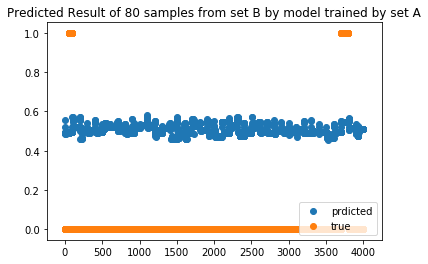

In [97]:
plt.figure(1)
plt.scatter(list(range(len(label))), res, )
plt.scatter(list(range(len(label))), label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 80 samples from set B by model trained by set A')

In [29]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_sao2', 'custom_ph',
                  'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']
bst2 = xgb.Booster(model_file='xgb_2019-07-22-09-58-17.model') 

def test(csv, bst2):
    #csv = 'p108230.psv'
    cur_train = pd.read_csv(f'./data/trainingA/' + csv, sep='|')
    cur_train = cur_train.fillna(method='pad')
    cur_train = feature_engineer(cur_train)[feature_to_use]

    encoder = LabelEncoder()
    custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                     'custom_resp', 'custom_hco3', 'custom_ph',
                     'custom_bun', 'custom_BC_ratio',
                     'custom_calcium', 'custom_chloride', 'custom_creatinine',
                     'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                     'custom_hct', 'custom_hgb', 'custom_wbc', 
                      'custom_platelets', 'Gender', 'Unit', 'HospAdmTime']

    for c in tqdm(custom):
        cur_train[c][0:len(cur_train[c])] = encoder.fit_transform(cur_train[c][0:len(cur_train[c])])

    encoded_x = None
    for f in custom:
        #print(f)
        enc = OneHotEncoder()
        fff = cur_train[f].to_numpy().reshape(cur_train[f].shape[0], 1)
        enc.fit(fff)
        array = enc.transform(fff).toarray()
        if encoded_x is None:
            encoded_x = array
        else:
            encoded_x = np.concatenate((encoded_x, array), axis=1)


    dtest = xgb.DMatrix(cur_train[custom])
    preds = bst2.predict(dtest)
    #print(preds)
    return preds, cur_train['SepsisLabel']

res = None
label = []
for i in tqdm(range(102,500,5)):
    R,l = test(f'p000{i}.psv', bst2)
    if res is None:
        res = R
    else:
        res = np.concatenate((res, R))
    label += list(l)
    
    
    
    
    


  0%|          | 0/80 [00:00<?, ?it/s]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.22it/s]

Data processed!



  1%|▏         | 1/80 [00:02<02:48,  2.13s/it]]

Begin!



  0%|          | 0/23 [00:00<?, ?it/s]

Data processed!
Begin!
Data processed!



  4%|▍         | 3/80 [00:06<02:39,  2.07s/it]]


Begin!
Data processed!


  5%|▌         | 4/80 [00:08<02:35,  2.04s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.43it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  8%|▊         | 6/80 [00:12<02:30,  2.04s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.72it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 10%|█         | 8/80 [00:16<02:25,  2.01s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.00it/s]

Data processed!



 11%|█▏        | 9/80 [00:18<02:28,  2.10s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.37it/s]


Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 15%|█▌        | 12/80 [00:24<02:18,  2.03s/it]

Begin!



  4%|▍         | 1/23 [00:00<00:02,  9.78it/s]


Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 20%|██        | 16/80 [00:32<02:07,  1.99s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.97it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 24%|██▍       | 19/80 [00:38<01:55,  1.89s/it]

Begin!



 25%|██▌       | 20/80 [00:39<01:52,  1.88s/it]

Data processed!
Begin!



 26%|██▋       | 21/80 [00:41<01:50,  1.87s/it]

Data processed!
Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.93it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 30%|███       | 24/80 [00:47<01:44,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.07it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


 36%|███▋      | 29/80 [00:56<01:34,  1.86s/it]

Begin!



  0%|          | 0/23 [00:00<?, ?it/s]

Data processed!
Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 42%|████▎     | 34/80 [01:06<01:25,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.94it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 52%|█████▎    | 42/80 [01:20<01:11,  1.87s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.62it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  9%|▊         | 2/23 [00:00<00:01, 15.65it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  9%|▊         | 2/23 [00:00<00:01, 14.40it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 64%|██████▍   | 51/80 [01:37<00:53,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.49it/s]

Data processed!



 65%|██████▌   | 52/80 [01:39<00:52,  1.88s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.94it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 70%|███████   | 56/80 [01:47<00:44,  1.85s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.46it/s]

Data processed!



 71%|███████▏  | 57/80 [01:48<00:42,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.15it/s]

Data processed!



 72%|███████▎  | 58/80 [01:50<00:41,  1.87s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 12.92it/s]


Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 75%|███████▌  | 60/80 [01:55<00:40,  2.01s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 12.77it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 78%|███████▊  | 62/80 [01:59<00:36,  2.05s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.14it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 80%|████████  | 64/80 [02:03<00:32,  2.04s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.13it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 82%|████████▎ | 66/80 [02:07<00:28,  2.03s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.29it/s]

Data processed!



 84%|████████▍ | 67/80 [02:09<00:26,  2.02s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.36it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 86%|████████▋ | 69/80 [02:13<00:22,  2.06s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.14it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


 89%|████████▉ | 71/80 [02:17<00:18,  2.00s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.70it/s]


Data processed!


 90%|█████████ | 72/80 [02:19<00:15,  1.98s/it]

Begin!



  0%|          | 0/23 [00:00<?, ?it/s]

Data processed!
Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 96%|█████████▋| 77/80 [02:28<00:05,  1.88s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.40it/s]

Data processed!



 98%|█████████▊| 78/80 [02:30<00:03,  1.87s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.31it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



100%|██████████| 80/80 [02:34<00:00,  1.88s/it]


Text(0.5, 1.0, 'Predicted Result of 80 samples from set A by model trained by set A')

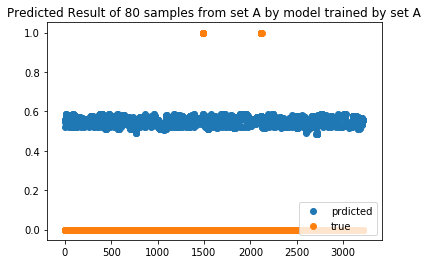

In [30]:
plt.figure(1)
plt.scatter(list(range(len(label))), res, )
plt.scatter(list(range(len(label))), label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 80 samples from set A by model trained by set A')

### Time-Series-XGBOOST

In [4]:
%reload_ext rpy2.ipython

In [5]:
%R print("Hi from R")

[1] "Hi from R"


array(['Hi from R'], dtype='<U9')

In [6]:
#%load_ext rpy2.ipython


%R
print("Hi from R")
print("Hi from R")

Hi from R
Hi from R


In [7]:
import rpy2
print(rpy2.__version__)

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')
#forecastxgb = importr('forecastxgb')
# import R's "utils" package
utils = importr('utils')

3.0.5


In [8]:
import rpy2.robjects as robjects
%reload_ext rpy2.ipython

In [12]:
%%R

#version
library(forecastxgb)
model <- xgbar(gas)
summary(model)


Importance of features in the xgboost model:
     Feature         Gain        Cover   Frequency
 1:    lag12 5.096008e-01 0.1166706236 0.068676717
 2:    lag11 2.795777e-01 0.0676836024 0.041876047
 3:    lag13 1.043150e-01 0.0243945869 0.025125628
 4:    lag24 7.806913e-02 0.1071937322 0.058626466
 5:     lag1 1.586491e-02 0.1826329535 0.185929648
 6:    lag23 5.628797e-03 0.0405389364 0.040201005
 7:     lag9 2.609947e-03 0.0850546059 0.061976549
 8:     lag2 6.965430e-04 0.0543091168 0.068676717
 9:    lag14 6.023859e-04 0.0474240266 0.030150754
10:    lag10 5.511717e-04 0.0367798354 0.045226131
11:     lag6 3.845375e-04 0.0114355809 0.030150754
12:     lag4 2.302062e-04 0.0073401393 0.033500838
13:    lag22 2.248839e-04 0.0096549541 0.018425461
14:    lag16 2.050286e-04 0.0069246597 0.011725293
15:    lag21 2.019113e-04 0.0170346629 0.025125628
16:    lag18 1.934416e-04 0.0197847420 0.026800670
17:     lag3 1.830137e-04 0.0202002216 0.036850921
18:     lag5 1.522916e-04 0.02427587

In [14]:
%%R
gas
model.

W0722 09:37:48.566647 4410422720 callbacks.py:116] R[write to console]: Error in model.predict() : could not find function "model.predict"
Calls: <Anonymous> -> <Anonymous> -> withVisible




Error in model.predict() : could not find function "model.predict"
Calls: <Anonymous> -> <Anonymous> -> withVisible


### LSTM

#### train

In [6]:
with open('./data/cut.pkl', 'rb') as file:
    meta_data = pickle.load(file)

In [7]:
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_ph',
                  'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']

# custom = ['custom_age', 'custom_hr',  'custom_temp', 
#                  'custom_resp', 'custom_hco3',
#                   'custom_bun', 'custom_BC_ratio',
#                  'custom_chloride', 'custom_creatinine',
#                  'custom_glucose', 'custom_potassium',
#                  'custom_hct', 'custom_hgb', 'custom_wbc', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']

now = int(round(time.time()*1000))
NOW = time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(now/1000))


train_data = meta_data[custom]
train_label = np.array(meta_data['SepsisLabel'])[:int(len(meta_data)//100) * 100]

encoder = {}
custom_ = copy.deepcopy(custom)
custom_.remove('HospAdmTime')
custom_.remove('ICULOS')

for c in tqdm(custom_):
    encoder[c] = LabelEncoder()
    train_data[c][0:len(train_data[c])] = encoder[c].fit_transform(train_data[c][0:len(train_data[c])])
    
output = open(f'Encoder_{NOW}.pkl', 'wb')
pickle.dump(encoder, output)
output.close()
    
train_data = np.array(train_data)[:int(len(meta_data)//100) * 100]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)

train_label = np.asarray(train_label).astype('float32')

# save encoder



100%|██████████| 22/22 [01:54<00:00,  2.92s/it]


In [8]:
with open('./data/train_data.pkl', 'wb') as file:
    pickle.dump(train_data,file)
with open('./data/train_label.pkl', 'wb') as file:
    pickle.dump(train_label,file)


reshape input to be [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [17]:
def sample_shuffle(train, label):
    normal = []
    abnormal = []
    
    for i in range(len(train)):
        if sum(label[i]) == 0: 
            normal.append(i)
        else:
            abnormal.append(i)
            
    random.shuffle(normal)
    normal = normal[:len(abnormal)] # sample to same for 1 and 0 training case
    normal = normal[:int(len(normal) * 1)]
    abnormal = abnormal[:int(len(abnormal) * 1)]
    index = normal + abnormal
    #print(len(normal), len(abnormal), len(index))
    random.shuffle(index) # shuffle
    return train[index], label[index]
    

train_size = len(meta_data)
num_features = len(custom)
patient_length = 100

# resize to [samples, time steps, features]
train_data = train_data.reshape(int(train_size/patient_length), patient_length, num_features)
train_label = train_label.reshape(int(train_size/patient_length),patient_length)

# sample and shuffle
train_data_ss, train_label_ss  = sample_shuffle(train_data, train_label)

# split
val_size = int(len(train_data_ss) * 0.2)
x_val = train_data_ss[len(train_data_ss) - val_size:]
partial_x_train = train_data_ss[:len(train_data_ss) - val_size]
y_val = train_label_ss[len(train_data_ss) - val_size:]
partial_y_train = train_label_ss[:len(train_data_ss) - val_size]


In [20]:
model = models.Sequential()
model.add(BatchNormalization()) 
model.add(LSTM(50, input_shape=(patient_length,num_features)))
model.add(layers.Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(patient_length,activation='sigmoid'))
#model.add(Dense(patient_length))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='binary_crossentropy', optimizer='adam')

W0725 16:24:24.080418 4588402112 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 11271 samples, validate on 2817 samples
Epoch 1/60
11271/11271 [==============================] - 79s 7ms/step - loss: 0.3968 - val_loss: 0.3711
Epoch 2/60
11271/11271 [==============================] - 71s 6ms/step - loss: 0.3825 - val_loss: 0.3578
Epoch 3/60
11271/11271 [==============================] - 74s 7ms/step - loss: 0.3717 - val_loss: 0.3477
Epoch 4/60
11271/11271 [==============================] - 69s 6ms/step - loss: 0.3521 - val_loss: 0.3393
Epoch 5/60
11271/11271 [==============================] - 79s 7ms/step - loss: 0.3474 - val_loss: 0.3236
Epoch 6/60
11271/11271 [==============================] - 70s 6ms/step - loss: 0.3570 - val_loss: 0.3574
Epoch 7/60
11271/11271 [==============================] - 69s 6ms/step - loss: 0.3827 - val_loss: 0.3694
Epoch 8/60
11271/11271 [==============================] - 68s 6ms/step - loss: 0.3730 - val_loss: 0.3360
Epoch 9/60
11271/11271 [==============================] - 67s 6ms/step - loss: 0.3409 - val_loss: 0.3249
Epoch 

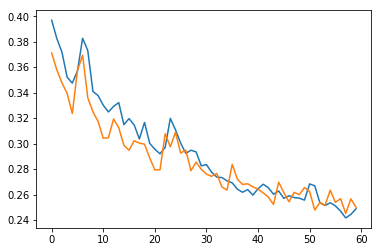

In [22]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=60, # 在全数据集上迭代200次
                    batch_size=10, # 每个batch的大小为1
                    validation_data=(x_val,y_val))

plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])

model.save(f'LSTM_{NOW}.h5')

#### test

In [12]:
!ls

A_group.csv                      data_analysis_images
B_group.csv                      evaluate_sepsis_score.py
Data_Preprocessing.ipynb         get_sepsis_test.py
EDA_and_Baseline.ipynb           kw.ipynb
Encoder_2019-07-24-22-28-37.pkl  labels.txt
Encoder_2019-07-24-23-01-38.pkl  labels.zip
Encoder_2019-07-24-23-05-22.pkl  others'works
Encoder_2019-07-24-23-07-11.pkl  output.zip
Encoder_2019-07-24-23-09-56.pkl  patient_a.txt
Encoder_2019-07-25-10-30-44.pkl  patient_b.txt
Encoder_2019-07-25-14-10-37.pkl  predictions.txt
Encoder_2019-07-25-14-16-20.pkl  predictions.zip
Encoder_2019-07-25-14-32-30.pkl  python-example-2019
Feature_Engineering.ipynb        reference
LSTM_2019-07-24-09-47-14.h5      result
LSTM_2019-07-24-09-47-29.h5      xgb_2019-07-17-14-05-28.model
LSTM_2019-07-24-16-02-03.h5      xgb_2019-07-17-14-18-07.model
LSTM_2019-07-24-16-52-48.h5      xgb_2019-07-18-10-14-55.model
LSTM_2019-07-24-17-23-26.h5      xgb_2019-07-18-10-34-18.model
LSTM_2019-07-24-22-28-37.h5      xgb

In [11]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_sao2', 'custom_ph',
                  'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']

def test(csv, encoder):
    model = load_model('LSTM_2019-07-25-14-32-30.h5')
    cur_train = pd.read_csv('./data/trainingB/' + csv, sep='|')
    org_length = len(cur_train)
    cur_train = cur_train.fillna(method='pad')
    cur_train = feature_engineer(cur_train)[feature_to_use]
    
    
    
    custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_ph',
                  'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']


#     custom = ['custom_age', 'custom_hr',  'custom_temp', 
#                  'custom_resp', 'custom_hco3',
#                   'custom_bun', 'custom_BC_ratio',
#                  'custom_chloride', 'custom_creatinine',
#                  'custom_glucose', 'custom_potassium',
#                  'custom_hct', 'custom_hgb', 'custom_wbc', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
    
    custom_ = copy.deepcopy(custom)
    custom_.remove('HospAdmTime')
    custom_.remove('ICULOS')
    
    encoder_ = LabelEncoder()
    for c in tqdm(custom_):
        #cur_train[c][0:len(cur_train[c])] = encoder_.fit_transform(cur_train[c][0:len(cur_train[c])])
        cur_train[c][0:len(cur_train[c])] = encoder[c].transform(cur_train[c][0:len(cur_train[c])])
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    dtest = np.array(cur_train[custom])
    dtest = dtest.reshape(-1,100,len(custom))
    preds = model.predict(dtest)
    
    #print(preds)
    return preds, cur_train['SepsisLabel'], org_length

res = None
org_label = []

test_dir = listdir('./data/trainingB/')
random.shuffle(test_dir)
test_candidate = test_dir[:50]
test_candidate += patient_b[:5]
random.shuffle(test_candidate)
org_length = []

pkl_file = open('Encoder_2019-07-25-14-32-30.pkl', 'rb')
encoder = pickle.load(pkl_file) 
pkl_file.close()
    
for i in tqdm(test_candidate):
    R,l,org_l = test(i, encoder)
    if res is None:
        res = list(R[0])
    else:
        res += list(R[0])
    org_label += list(l)
    org_length.append(org_l)
    


  0%|          | 0/55 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0725 15:13:07.496389 4546074048 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 15:13:07.509993 4546074048 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 15:13:07.512726 4546074048 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 15:13:07.734642 4546074048 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.c

 82%|████████▏ | 18/22 [00:05<00:01,  3.02it/s]


 76%|███████▋  | 42/55 [10:36<06:04, 28.00s/it]


100%|██████████| 55/55 [17:33<00:00, 33.25s/it]


Text(0.5, 1.0, 'Predicted Result of 10 samples from set B by model trained by set A')

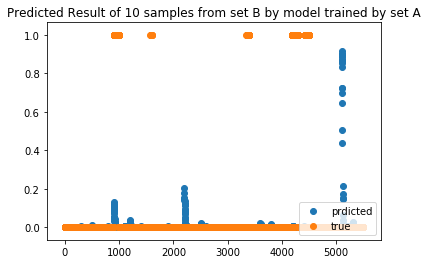

In [12]:
plt.figure(1)
plt.scatter(list(range(len(org_label))), res )
plt.scatter(list(range(len(org_label))), org_label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 10 samples from set B by model trained by set A')

In [13]:
from evaluate_sepsis_score import *
import os, zipfile
Res = res
gap = max(Res) - 0 + 0.01
Res = (Res / gap)
Res = [abs(x) for x in Res]
threshold = 0.5
prefix_length = [org_length[0]]
for i in range(1, len(org_length)):
    prefix_length.append(org_length[i] + prefix_length[i-1])
    
def fix_100(res, label, org_length, t):
    """
    input: 
            res label are given by predict
            org_length is the original length of each patient
            t is threshold
    output:
            fixed probabilities, original labels and predictions of original length,
            also processed by threshold
            
    """
    l = 100 # fixed length of each patient
    Res = []
    Label = []
    Predict = []
    for i in range(len(org_length)):
        tmp_res = res[i*l:(i+1)*l]
        tmp_label = label[i*l:(i+1)*l]
        if org_length[i] <= l:
            tmp_res = tmp_res[:org_length[i]]
            tmp_label = tmp_label[:org_length[i]]
        else:
            last = tmp_res[-1]
            tmp_res += [last for _ in range(org_length[i] - l)]
            tmp_label += [tmp_label[-1] for _ in range(org_length[i] - l)]
        tmp_predict = [1 for _ in range(len(tmp_res))]
        for r in range(len(tmp_res)):
            if tmp_res[r] < t:
                tmp_predict[r] = 0
            else:    
                r += 1
                while r < len(tmp_res):
                    tmp_res[r] = tmp_res[r - 1]
                    r += 1
                    
                break
                
        Predict += tmp_predict
        Res += tmp_res
        Label += tmp_label
    return Res, Label, Predict 
        
Res, Label, predicts = fix_100(Res, org_label, org_length, threshold)

with open('labels.txt', 'w') as f:
    f.write('SepsisLabel\n')
    if len(Label) != 0:
        for l in Label:
            f.write('%d\n' % l)
            
with open('predictions.txt', 'w') as f:
    f.write('PredictedProbability|PredictedLabel\n')
    if len(Res) != 0:
        for (s, l) in zip(Res, predicts):
            f.write('%g|%d\n' % (s, l))
        
with zipfile.ZipFile('labels.zip', 'w') as z:
    z.write('labels.txt')
with zipfile.ZipFile('predictions.zip', 'w') as z:
    z.write('predictions.txt')    

!python3 evaluate_sepsis_score.py labels.zip predictions.zip


0.969536 0.221815
AUROC|AUPRC|Accuracy|F-measure|Utility
0.40121556285349386|0.02984535331015096|0.9552880481513327|0.0|0.0
AUROC|AUPRC|Accuracy|F-measure|Utility
0.40121556285349386|0.02984535331015096|0.9552880481513327|0.0|0.0


Text(0.5, 1.0, 'Predicted Result of 10 samples from set B by model trained by set A')

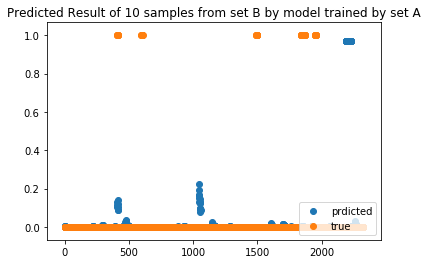

In [16]:
#plt.figure(1)
plt.scatter(list(range(len(Label))), Res)
plt.scatter(list(range(len(Label))), Label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 10 samples from set B by model trained by set A')

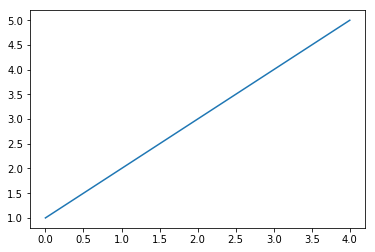

In [17]:
plt.figure(1)
plt.plot(list(range(5)),[1,2,3,4,5])
    

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import csv
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
data=[]
traffic_feature=[]
traffic_target=[]
csv_file = csv.reader(open('packSize_all.csv'))
for content in csv_file:
    content=list(map(float,content))
    if len(content)!=0:
        data.append(content)
        traffic_feature.append(content[0:6])
        traffic_target.append(content[-1])
print('data=',data)
print('traffic_feature=',traffic_feature)
print('traffic_target=',traffic_target)
scaler = StandardScaler() # 标准化转换
scaler.fit(traffic_feature)  # 训练标准化对象
traffic_feature= scaler.transform(traffic_feature)   # 转换数据集
feature_train, feature_test, target_train, target_test = train_test_split(traffic_feature, traffic_target, test_size=0.3,random_state=0)
# clf = RandomForestClassifier(criterion='entropy')
clf = RandomForestClassifier()
clf.fit(feature_train,target_train)
predict_results=clf.predict(feature_test)
print(accuracy_score(predict_results, target_test))
conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)
print(classification_report(target_test, predict_results))
